In [4]:
import xarray as xr
import numpy as np
import scipy.signal as signal

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean
import cartopy.crs as ccrs
import matplotlib.transforms as mtransforms
import matplotlib.lines as mlines
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D

## Load data for specific figure

### Figure 1, 2, 3
#### Data Note: Internal wave energy flux at a fixed site (154.5°E, 45°S)
"""
This dataset represents an internal wave energy flux example at 154.5°E, 45°S in the Tasman Sea, 
a site of historical mooring measurements.It includes time–depth resolved variables relevant to internal wave energetics, with decompositions into semidiurnal, near-inertial, and continuum bands.

- Dimensions:
  - time: 4095 hourly steps (2012-05-29 to 2012-11-15)
  - depth: 90 vertical levels

- Coordinates:
  - time: datetime64[ns]
  - depth: Depth (m, positive downward)
  - x, y, z: LLC4320 grid indices (site location)
    - Note: x is non-monotonic due to 180°W–180°E sorting
  - lon, lat: Site longitude and latitude (degrees)
  - bottom_depth: Seafloor depth at site (m, positive downward)

- Data variables (time, depth):
  - Pcl, PclH, PclL: Total, high-pass, and low-pass baroclinic pressure (Pa)
  - Vcl, VclH, VclL: Total, high-pass, and low-pass baroclinic velocity (m/s)
  - pcl_inertial, pcl_m2, pcl_background: Baroclinic pressure in near-inertial, semidiurnal, and continuum bands (Pa)
  - vcl_inertial, vcl_m2, vcl_background: Baroclinic velocity in near-inertial, semidiurnal, and continuum bands (m/s)

- Data variables (time):
  - Ecl: Depth-integrated internal wave energy flux (W/m²)
  - EclH, EclL: Depth-integrated flux from high-pass and low-pass components (W/m²)
  - Ecl_PclH_VclL, Ecl_PclL_VclH: Depth-integrated flux from high-pass pressure and low-pass velocity, and from low-pass pressure and high-pass velocity, respectively (W/m²)
  - Ecl_inertial, Ecl_m2, Ecl_continuum: Depth-integrated flux in near-inertial, semidiurnal, and continuum bands (W/m²)


- Notes:
  - flux is positive equatorward and negative poleward.
  - Band separation follows methods described described in the paper.
"""


In [5]:
ds_example_site = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/ds_example_site.nc',engine = 'netcdf4')
ds_example_site

<xarray.Dataset> Size: 36MB
Dimensions:         (time: 4095, depth: 90)
Coordinates:
  * time            (time) datetime64[ns] 33kB 2012-05-29 ... 2012-11-15T14:0...
    x               int64 8B ...
    y               int64 8B ...
    z               (depth) int64 720B ...
    lon             float64 8B ...
    lat             int64 8B ...
  * depth           (depth) float32 360B -0.5 -1.57 ... -6.301e+03 -6.76e+03
Data variables: (12/21)
    Pcl             (time, depth) float64 3MB ...
    PclH            (time, depth) float64 3MB ...
    PclL            (time, depth) float64 3MB ...
    Vcl             (time, depth) float64 3MB ...
    VclH            (time, depth) float64 3MB ...
    VclL            (time, depth) float64 3MB ...
    ...              ...
    EclL            (time) float64 33kB ...
    Ecl_inertial    (time) float64 33kB ...
    Ecl_m2          (time) float64 33kB ...
    Ecl_continuum   (time) float64 33kB ...
    Ecl_PclH_VclL   (time) float64 33kB ...
    Ecl_PclL_VclH   (time) float64 33kB ...

### Figure 4

#### Data Note: Bandpass-filtered near-inertial wind work at a fixed site (154.5°E, 45°S)

"""
This dataset provides bandpass-filtered wind stress and velocity time series 
at a fixed site (154.5°E, 45°S) from the LLC4320 simulation.

- Dimensions:
  - time: 4095 hourly steps (2012-05-29 to 2012-11-15)

- Coordinates:
  - time: datetime64[ns]

- Data variables (time):
  - taux, tauy: Zonal and meridional wind stress components (Pa)
  - Z_real, Z_imag: Zonal and meridional velocities in the near-inertial band (m/s)
  - niw: Near-inertial wind power input (W/m²)

- Notes:
  - Near-inertial bandpass filtering follows the method described in the paper.
"""


In [6]:
ds_site_bandpass = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/ds_site_bandpass.nc',engine = 'netcdf4')
display(ds_site_bandpass)

<xarray.Dataset> Size: 164kB
Dimensions:  (time: 4095)
Coordinates:
  * time     (time) datetime64[ns] 33kB 2012-05-29 ... 2012-11-15T14:00:00
Data variables:
    taux     (time) float64 33kB ...
    tauy     (time) float64 33kB ...
    Z_real   (time) float32 16kB ...
    Z_imag   (time) float32 16kB ...
    niw      (time) float64 33kB ...

### Figure 5, 6, 7, 8

#### Data Note: Time-mean internal wave energy fluxes at 35°S, 45°S, 55°S, and 65°S

"""
This dataset contains time-mean vertical profiles of internal wave energy fluxes 
from the LLC4320 model along four latitude transects: 35°S, 45°S, 55°S, and 65°S.

For example, ds_flux_mean_sorted_35S includes:
- Dimensions:
  - x: 17280 points (zonal)
  - y: 1 point (fixed latitude)
  - z: 90 vertical levels

- Coordinates:
  - x, y, z: LLC4320 grid indices (y is fixed at 35°S)
  - lon, lat: Geographic coordinates (longitude re-sorted from 180°W to 180°E)
  - depth: Cell depth (m, positive downward)
  - RC: Midpoint depth of each grid cell
  - hFacC: Ocean fraction of each grid cell (1 = full ocean, 0 = land)

- Data variables (x, y, z):
  - flux_total: Time-mean vertical energy flux (W/m²), all frequencies
  - flux_m2: Flux in the semidiurnal tidal band
  - flux_inertial: Flux in the near-inertial band  
  - flux_continuum: Flux in the continuum (non-tidal, non-inertial) band
  - flux_cross: Cross-band flux from mismatched pressure and velocity (e.g., pressure from one band, velocity from another)

- Notes:
  - All fluxes are in W/m², positive equatorward and negative poleward.
  - Band separation follows methods described described in the paper.

"""



In [7]:
ds_flux_mean_sorted_35S = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/F/ds_flux_mean_sorted_35S.nc',engine = 'netcdf4')
ds_flux_mean_sorted_45S = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/F/ds_flux_mean_sorted_45S.nc',engine = 'netcdf4')
ds_flux_mean_sorted_55S = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/F/ds_flux_mean_sorted_55S.nc',engine = 'netcdf4')
ds_flux_mean_sorted_65S = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/F/ds_flux_mean_sorted_65S.nc',engine = 'netcdf4')

ds_flux_mean_sorted_35S

<xarray.Dataset> Size: 31MB
Dimensions:              (x: 17280, y: 1, z: 90)
Coordinates:
  * x                    (x) int64 138kB 10465 10466 10467 ... 10462 10463 10464
  * y                    (y) int64 8B 5972
  * z                    (z) int64 720B 1 2 3 4 5 6 7 8 ... 84 85 86 87 88 89 90
    lon                  (x, y) float32 69kB ...
    lat                  (x, y) float32 69kB ...
    depth                (z) float32 360B ...
Data variables:
    EclH_mean            (x, y, z) float32 6MB ...
    Ecl_inertial_mean    (x, y, z) float32 6MB ...
    Ecl_m2_mean          (x, y, z) float32 6MB ...
    Ecl_background_mean  (x, y, z) float32 6MB ...
    Ecl_residual_mean    (x, y, z) float32 6MB ...

### Figure 9

#### Data Note: LLC4320 Bathymetry Grid (`ds_grid`)

"""
Dataset: ds_grid

This dataset provides seafloor topography from the LLC4320 global ocean simulation.

- Coordinates:
  - x, y: Zonal and meridional grid indices

- Data variables:
  - lon (x, y): Longitude in degrees (0–360)
  - lat (x, y): Latitude in degrees (−90 to 90)
  - bottom_depth (x, y): Seafloor depth in meters (positive downward)
"""


In [8]:
ds_grid = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/ds_grid.nc',engine='netcdf4')
ds_grid

<xarray.Dataset> Size: 3GB
Dimensions:       (x: 17280, y: 12960)
Coordinates:
  * x             (x) int64 138kB 1 2 3 4 5 6 ... 17276 17277 17278 17279 17280
  * y             (y) int64 104kB 1 2 3 4 5 6 ... 12956 12957 12958 12959 12960
Data variables:
    lon           (x, y) float32 896MB ...
    lat           (x, y) float32 896MB ...
    bottom_depth  (x, y) float32 896MB ...

### Figure 9

#### Data Note: Depth-integrated energy fluxes at 35°S, 45°S, 55°S, and 65°S

"""
This dataset provides depth-integrated internal wave energy fluxes from the LLC4320 model 
along four latitude transects: 35°S, 45°S, 55°S, and 65°S. Each file contains time-mean 
fluxes and monthly standard errors for both the semidiurnal and near-inertial bands.

For example, (`ds_Edz_35S_sorted`) includes:
- Coordinates:
  - x, y: LLC4320 horizontal grid indices
  - lon, lat: Geographic coordinates (longitude re-sorted from 180°W to 180°E)
  - bottom_depth: Local ocean bottom depth (positive downward)

- Data variables:
  - Ecl_m2_dz_mean, Ecl_inertial_dz_mean: Time-mean fluxes (W/m)
  - Ecl_m2_dz_monthly_error, Ecl_inertial_dz_monthly_error: Monthly standard errors (W/m)

The datasets for 45°S, 55°S, and 65°S (ds_Edz_45S_sorted, ds_Edz_55S_sorted, ds_Edz_65S_sorted) 
have the same structure as ds_Edz_35S_sorted, but correspond to different latitudes.
"""


In [9]:
ds_Edz_35S_sorted = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/F_dz/ds_Edz_35S_sorted.nc',engine='netcdf4')
ds_Edz_45S_sorted = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/F_dz/ds_Edz_45S_sorted.nc',engine='netcdf4')
ds_Edz_55S_sorted = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/F_dz/ds_Edz_55S_sorted.nc',engine='netcdf4')
ds_Edz_65S_sorted = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/F_dz/ds_Edz_65S_sorted.nc',engine='netcdf4')


### Figure 10
This dataset contains zonally cumulative depth-integrated internal wave energy fluxes 
from the LLC4320 model along four Southern Ocean transects: 35°S, 45°S, 55°S, and 65°S.

For example, `ds_cumulative_35S` includes:

- Coordinates:
  - x, y: LLC4320 horizontal grid indices
  - lon, lat: Geographic coordinates (longitude re-sorted from 180°W to 180°E)

- Data variables (x, y):
  - Ecl_m2_cumulative_mean: Time-mean zonally cumulative flux in the semidiurnal band (W)
  - Ecl_m2_cumulative_monthly_std: Monthly standard deviation of semidiurnal flux (W)
  - Ecl_inertial_cumulative_mean: Time-mean zonally cumulative flux in the near-inertial band (W)
  - Ecl_inertial_cumulative_monthly_std: Monthly standard deviation of near-inertial flux (W)

- Notes:
  - Flux is positive equatorward and negative poleward.
  - Band separation follows methods described in the paper.


In [10]:
ds_cumulative_35S = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/cumulative_flux/ds_cumulative_35S.nc', engine='netcdf4')
ds_cumulative_45S = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/cumulative_flux/ds_cumulative_45S.nc', engine='netcdf4')
ds_cumulative_55S = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/cumulative_flux/ds_cumulative_55S.nc', engine='netcdf4')
ds_cumulative_65S = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/cumulative_flux/ds_cumulative_65S.nc', engine='netcdf4')

ds_cumulative_35S

<xarray.Dataset> Size: 553kB
Dimensions:                                (x: 17280, y: 1)
Coordinates:
    lon                                    (x, y) float32 69kB ...
    lat                                    (x, y) float32 69kB ...
  * x                                      (x) int64 138kB 10465 10466 ... 10464
  * y                                      (y) int64 8B 5972
Data variables:
    Ecl_inertial_cumulative_mean           (x, y) float32 69kB ...
    Ecl_inertial_cumulative_monthly_error  (x, y) float32 69kB ...
    Ecl_m2_cumulative_mean                 (x, y) float32 69kB ...
    Ecl_m2_cumulative_monthly_error        (x, y) float32 69kB ...

### Figure 11

#### Data Note: Near-inertial wind work poleward of 35°S

"""
This dataset contains bandpassed near-inertial wind work from LLC4320, using wind stress and bandpass-filtered velocities.

For example, (`ds_Edz_35S_sorted`) includes:
- Coordinates:
  - x, y: LLC4320 horizontal grid indices
  - lon, lat: Geographic coordinates (longitude re-sorted from 180°W to 180°E)
  - bottom_depth: Local ocean bottom depth (positive downward)

- Data variables:
  - Ecl_m2_mean, Ecl_inertial_mean: Time-mean fluxes (W/m)
  - Ecl_m2_monthly_std, Ecl_inertial_monthly_std: Monthly standard deviations (W/m)

The datasets for 45°S, 55°S, and 65°S (ds_Edz_45S_sorted, ds_Edz_55S_sorted, ds_Edz_65S_sorted) 
have the same structure as ds_Edz_35S_sorted, but correspond to different latitudes.
"""

In [11]:
ds_niw_z = xr.open_dataset('/data/SO12/TEMP/youran/LLC4320/data_archive/public_v2/ds_niw_z.nc', engine = 'netcdf4')
ds_niw_z


<xarray.Dataset> Size: 2GB
Dimensions:       (x: 17280, y: 5982)
Coordinates:
  * x             (x) int64 138kB 1 2 3 4 5 6 ... 17276 17277 17278 17279 17280
  * y             (y) int64 48kB 1 2 3 4 5 6 7 ... 5977 5978 5979 5980 5981 5982
Data variables:
    lon           (x, y) float32 413MB ...
    lat           (x, y) float32 413MB ...
    bottom_depth  (x, y) float32 413MB ...
    niw_bandpass  (x, y) float32 413MB ...

## PLOT

### Figure 1

In [12]:
# Figures 1
# -------------------------------------- Calculate spectra  ------------------------------------------
dt = 1  # Time step in hours

# for Pcl 
fsp, pcl_sp = signal.welch(
    ds_example_site['Pcl'],      # Input data (Pcl)
    fs=1 / dt,          # Sampling frequency
    window='hann',      # Hann window
    nperseg=ds_example_site['Pcl'].shape[0],  # Number of samples in each segment
    noverlap=0,         # No overlap between segments
    detrend='constant', # Remove the mean before computing the FFT
    scaling='density',  # Compute power spectral density (Pa^2/cph)
    axis=0              # Perform Welch along the time dimension
)

# for vcl
fsp, vcl_sp = signal.welch(
    ds_example_site['Vcl'],  
    fs=1 / dt,          # Sampling frequency
    window='hann',      # Hann window
    nperseg=ds_example_site['Pcl'].shape[0],  # Number of samples in each segment
    noverlap=0,         # No overlap between segments
    detrend='constant', # Remove the mean before computing the FFT
    scaling='density',  # Compute power spectral density (Pa^2/cph)
    axis=0              # Perform Welch along the time dimension
)

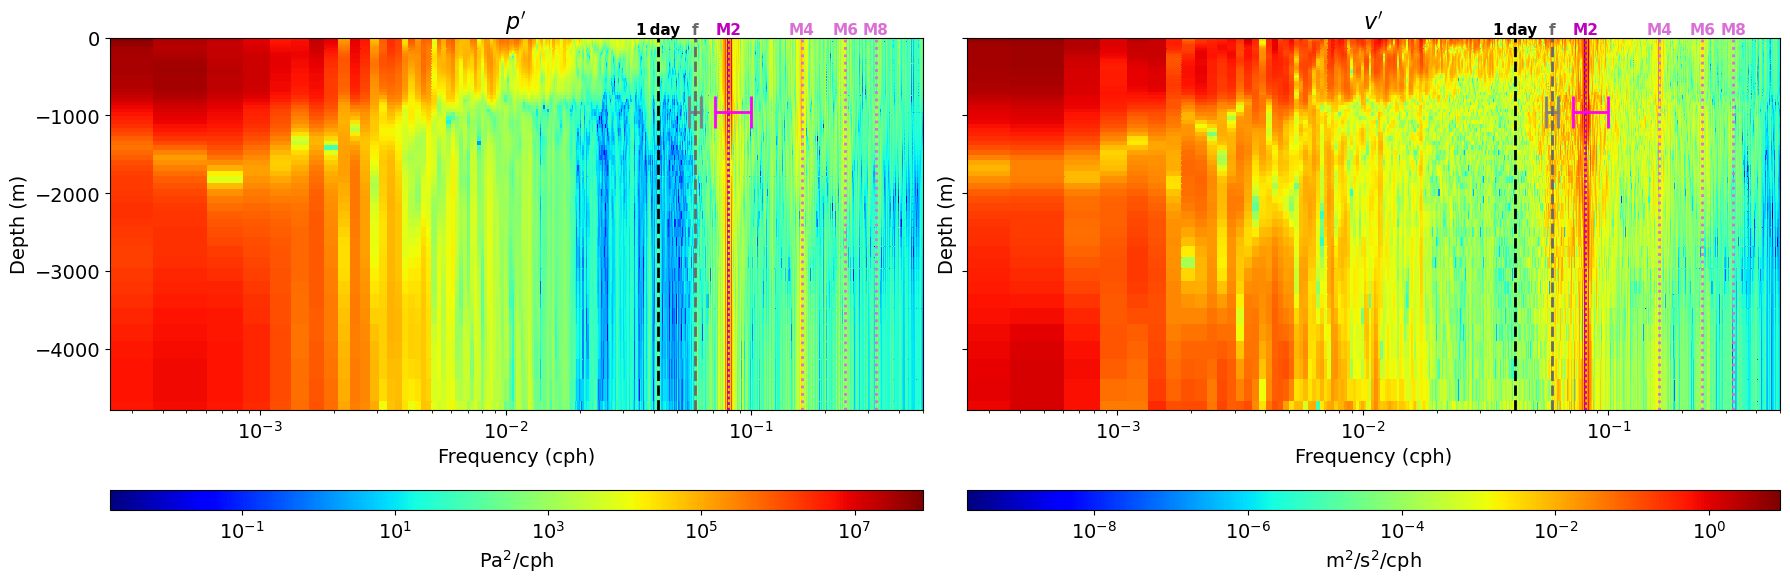

In [65]:
omega = 2 * np.pi / 86400

from matplotlib.colors import LogNorm

fontsize_title     = 16   # subplot titles
fontsize_label     = 14   # axis labels
fontsize_tick      = 14
fontsize_colorbar  = 14   # color-bar label and ticks

bottom_depth = ds_example_site["bottom_depth"].values.item()

# Calculate fundamental and Nyquist frequencies
dt = 1  # Sampling interval in hours
total_time = (ds_example_site['time'][-1] - ds_example_site['time'][0]) / np.timedelta64(1, 'h')
total_time_24hr_hp = (ds_example_site['time'][12:-12][-1] - ds_example_site['time'][12:-12][0]) / np.timedelta64(1, 'h')
fundamental_freq = 1 / total_time  # Fundamental frequency in cph
fundamental_freq_24hr_hp = 1 / total_time_24hr_hp
nyquist_freq = 0.5 / dt  # Nyquist frequency in cph

# Define near-inertial and M2 frequency
f = 2 * omega * abs(np.sin(np.deg2rad(-45))) * (3600 * 24 / (2 * np.pi)) / 24
m2_freq = 1 / 12.42
oneday_freq = 1/24

# Define bands
c = 1.06
inertial_band = (f / c, f * c)
semidiurnal_band = (1 / 14, 1 / 10)

freq_lines = [
    (f, 'dimgrey', '--', 'Inertial'),
    (m2_freq, 'm', (0, (1, 1)), 'M2'),
    (oneday_freq, 'black', '--', '1-day'),
    (2 * m2_freq, 'orchid', ':', 'M4'),
    (3 * m2_freq, 'orchid', ':', 'M6'),
    (4 * m2_freq, 'orchid', ':', 'M8')
]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot Pcl in the first subplot
p1 = axes[0].pcolor(fsp, ds_example_site['depth'].values, np.squeeze(pcl_sp).T, cmap='jet', norm=LogNorm(), shading='auto')
axes[0].set_title(r"$p'$ ",fontsize=fontsize_title)
axes[0].set_xscale('log')
axes[0].set_xlabel('Frequency (cph)',fontsize=fontsize_label)
axes[0].set_xlim([fundamental_freq, nyquist_freq])

# Plot Vcl in the first subplot
v1 = axes[1].pcolor(fsp, ds_example_site['depth'].values, np.squeeze(vcl_sp).T, cmap='jet', norm=LogNorm(), shading='auto',label = 'm/s')
axes[1].set_title(r"$v'$ ",fontsize=fontsize_title)
axes[1].set_xscale('log')
axes[1].set_xlabel('Frequency (cph)',fontsize=fontsize_label)
axes[1].set_xlim([fundamental_freq, nyquist_freq])

for ax in axes:
    ax.tick_params(axis='both', labelsize=fontsize_tick)  


for ax in axes:
    ax.tick_params(axis='both', labelsize=fontsize_tick)
    ax.set_ylim([-bottom_depth, 0])
    ax.set_ylabel('Depth (m)', fontsize=fontsize_label)

    y_bracket = -bottom_depth * 0.2  # Adjust based on how deep you want to draw the brackets
    # Inertial band
    ax.hlines(y_bracket, inertial_band[0], inertial_band[1], color='gray', linewidth=2)
    ax.vlines([inertial_band[0], inertial_band[1]], y_bracket - 200, y_bracket + 200, color='gray', linewidth=2)

    # Semidiurnal band
    y_bracket2 = y_bracket # -bottom_depth * 0.3
    ax.hlines(y_bracket2, semidiurnal_band[0], semidiurnal_band[1], color='magenta', linewidth=2)
    ax.vlines([semidiurnal_band[0], semidiurnal_band[1]], y_bracket2 - 200, y_bracket2 + 200, color='magenta', linewidth=2)

    # Frequency reference lines
    for freq, color, linestyle, label in freq_lines:
        ax.axvline(x=freq, color=color, linestyle=linestyle, linewidth=2)

    # Label text at top
    y_text = 10  # depth position for text labels
    txt_kw = dict(ha='center', va='bottom', fontsize=11, weight='bold')
    ax.text(f, y_text, 'f', color='dimgray', **txt_kw)
    ax.text(m2_freq, y_text, 'M2', color='m', **txt_kw)
    ax.text(oneday_freq, y_text, '1 day', color='black', **txt_kw)
    ax.text(2 * m2_freq, y_text, 'M4', color='orchid', **txt_kw)  
    ax.text(3 * m2_freq, y_text, 'M6', color='orchid', **txt_kw) 
    ax.text(4 * m2_freq, y_text, 'M8', color='orchid', **txt_kw)
    
# Set shared axis limits
axes[0].set_ylabel('Depth (m)',fontsize=fontsize_label)
axes[0].set_ylim([-bottom_depth, 0])

# colour-bar 
cbar1 = fig.colorbar(p1, ax=axes[0],orientation='horizontal',pad=0.15,aspect=40)
cbar1.set_label(r"$\mathrm{Pa}^2/\mathrm{cph}$", fontsize=fontsize_colorbar)         
cbar1.ax.tick_params(labelsize=fontsize_colorbar)        

cbar2 = fig.colorbar(v1, ax=axes[1],orientation='horizontal',pad=0.15,aspect=40)
cbar2.set_label(r"$\mathrm{m}^2/\mathrm{s}^2/\mathrm{cph}$", fontsize=fontsize_colorbar)
cbar2.ax.tick_params(labelsize=fontsize_colorbar)

plt.tight_layout()
plt.show()

### Figure 2

/tmp/ipykernel_2243890/1540283605.py:34: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(plot, cax=cax, ticks=ticks)
/tmp/ipykernel_2243890/1540283605.py:34: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(plot, cax=cax, ticks=ticks)
/tmp/ipykernel_2243890/1540283605.py:34: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(plot, cax=cax, ticks=ticks)
/tmp/ipykernel_2243890/1540283605.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMe

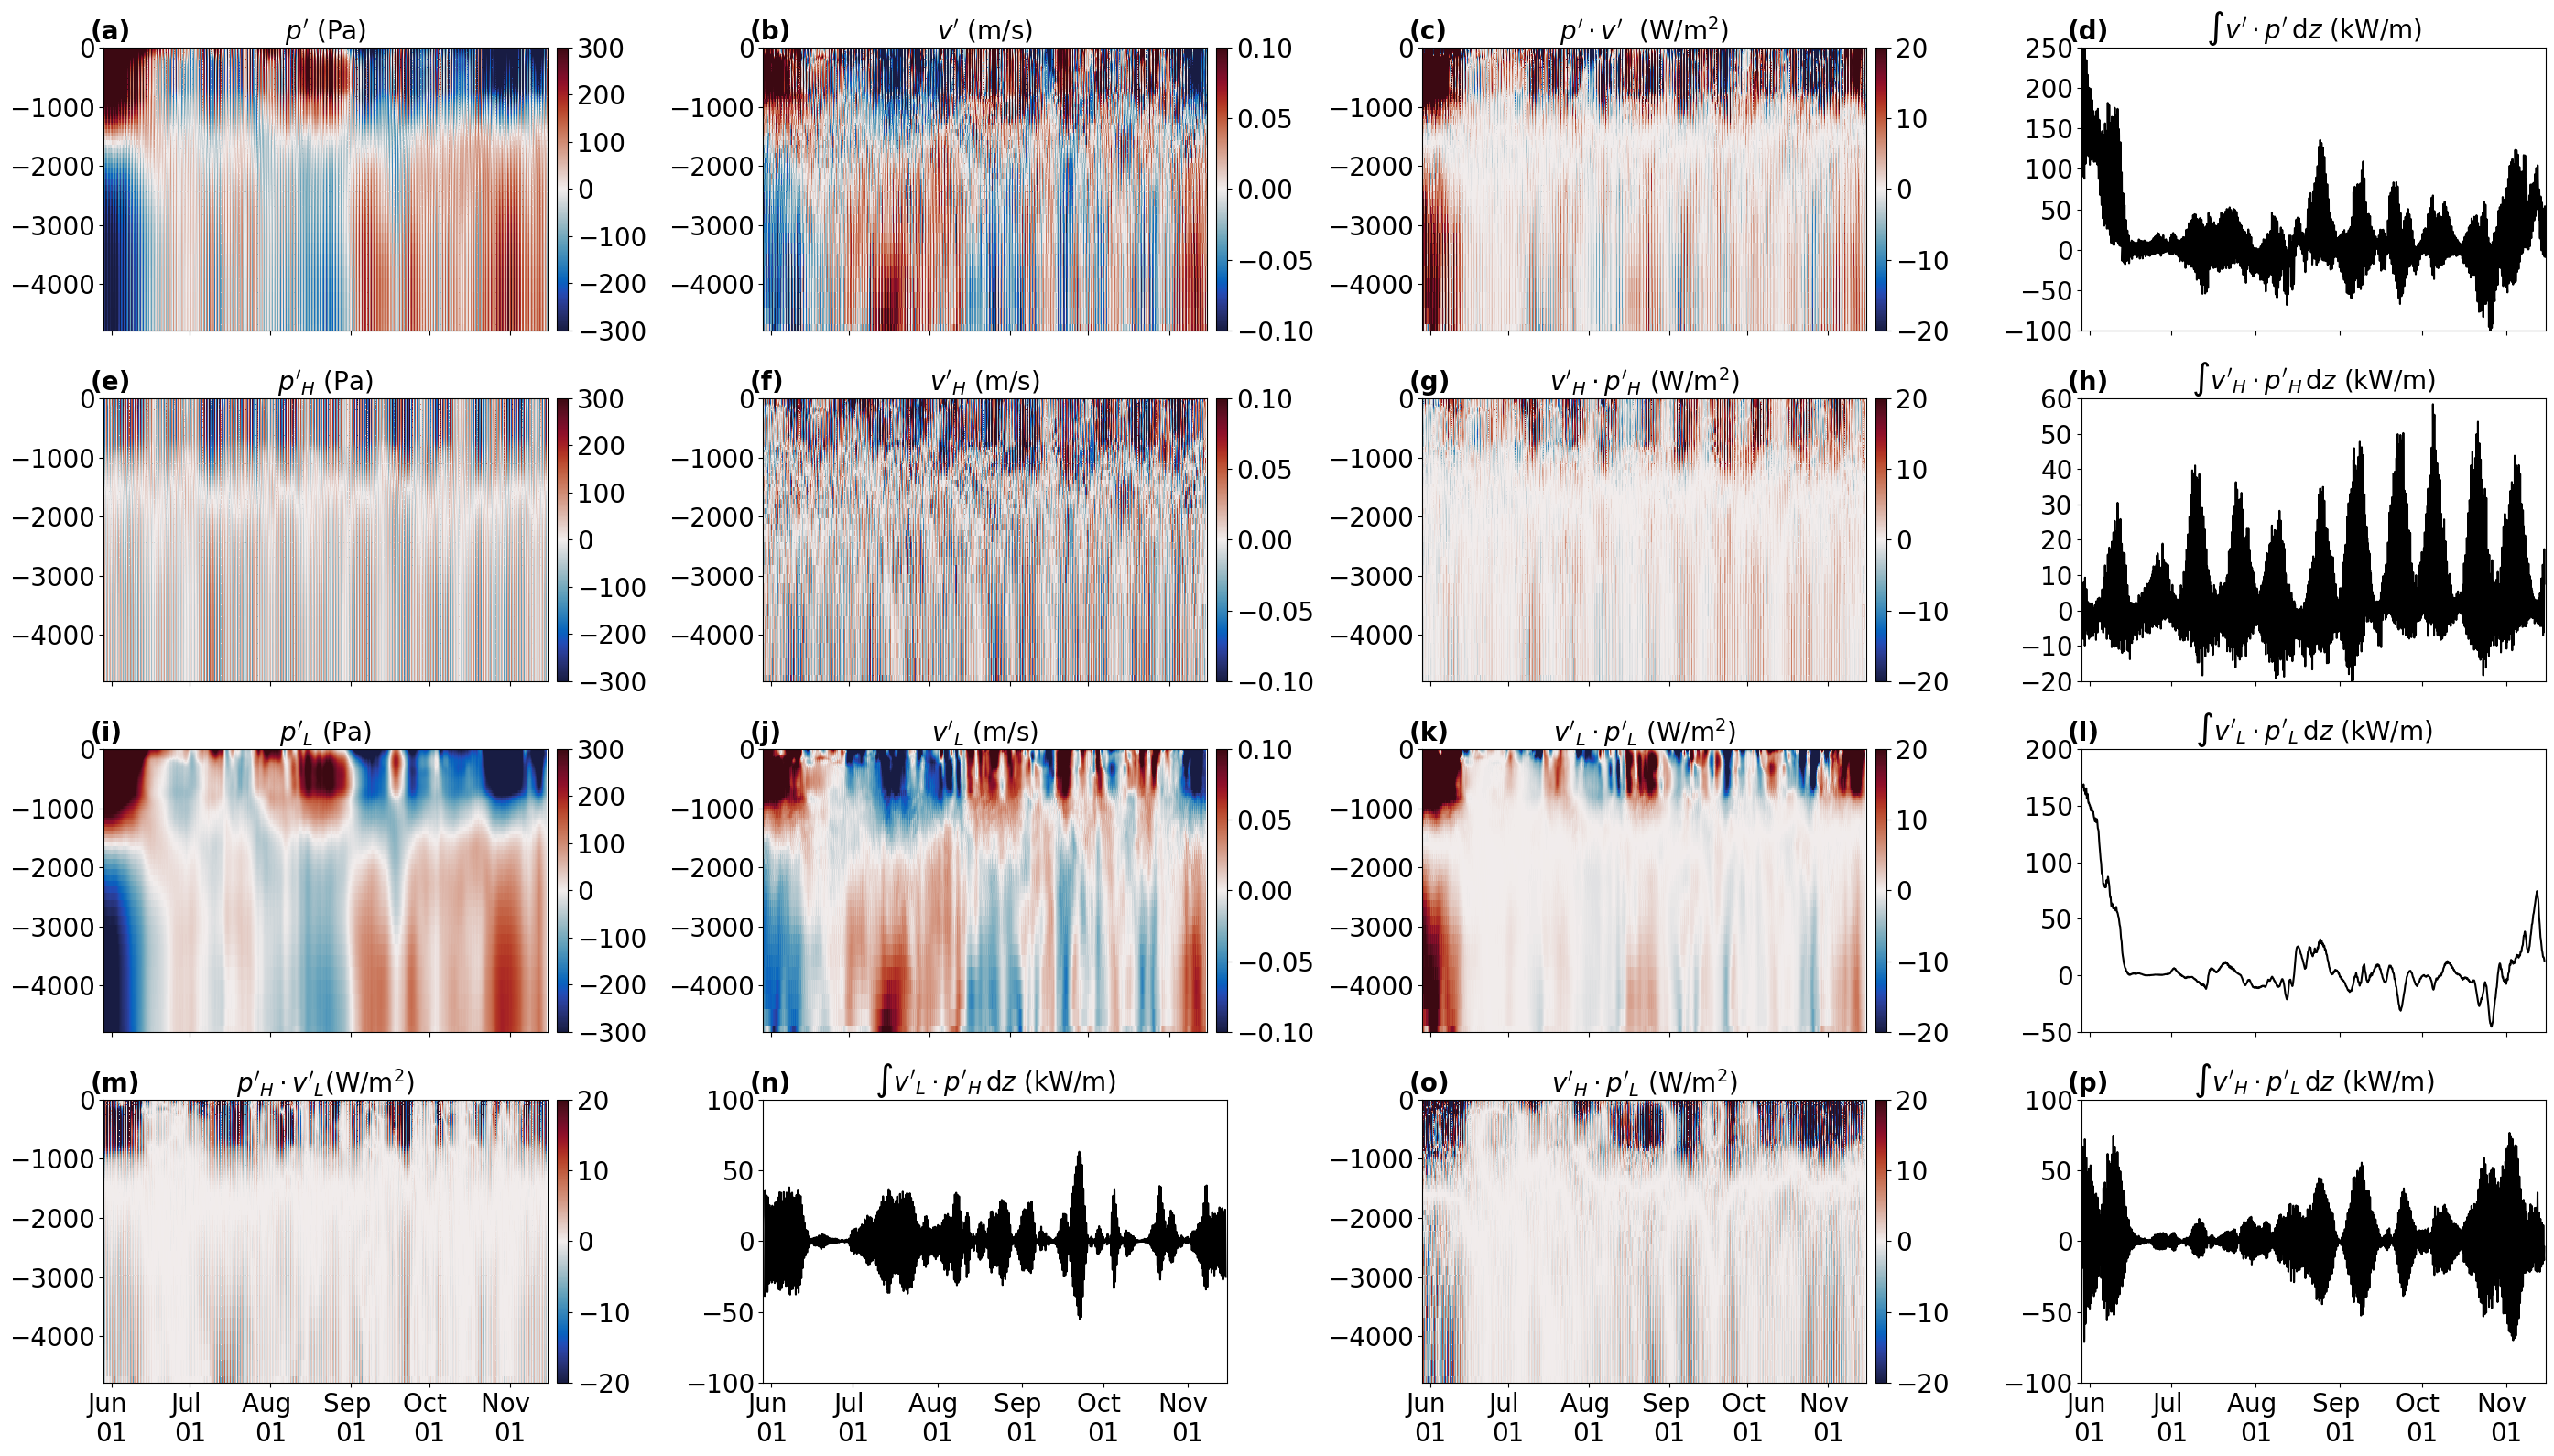

In [13]:
bottom_depth = ds_example_site["bottom_depth"].values.item()
font_size = 20
plim = [-300, 300]
vlim = [-0.1, 0.1]
pvlim = [-20, 20]

# Create subplots: 4 rows and 4 columns
fig, axes = plt.subplots(4, 4, figsize=(28, 16), sharex=True)
axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b \n%d'))  # Format: 'Jun \n01'

# Manually make the first three columns share the same y-axis
axes[0, 1].sharey(axes[0, 0])
axes[0, 2].sharey(axes[0, 0])
axes[1, 0].sharey(axes[0, 0])
axes[1, 1].sharey(axes[0, 0])
axes[1, 2].sharey(axes[0, 0])
axes[2, 0].sharey(axes[0, 0])
axes[2, 1].sharey(axes[0, 0])
axes[2, 2].sharey(axes[0, 0])
axes[3, 0].sharey(axes[0, 0])
axes[3, 2].sharey(axes[0, 0])

# Set vertical limits for the first three columns
axes[0, 0].set_ylim([-bottom_depth, 0])


from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_colorbar_to_subplot(plot, ax, label, clim, ticks='auto'):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.1)  # Adjust size and padding
    if isinstance(ticks, str) and ticks == 'auto':
        cbar = fig.colorbar(plot, cax=cax)
    else:
        cbar = fig.colorbar(plot, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=font_size)
    
# Data for subplots (example: pressure, velocity, dot products)
subplots = [
    (ds_example_site['Pcl'], axes[0, 0], r"$p' \ $(Pa)", plim, 'Pa'),
    (ds_example_site['PclH'], axes[1, 0], r"$p'_{H} \ $(Pa)", plim, 'Pa'),
    (ds_example_site['PclL'], axes[2, 0], r"$p'_{L} \ $(Pa)", plim, 'Pa'),
    (ds_example_site['PclH'] * ds_example_site['VclL'], axes[3, 0], r"$p'_{H} \cdot v'_{L} $(W/m$^2$)", pvlim, '(W/m²)'),
    (ds_example_site['Vcl'], axes[0, 1], r"$v' \ $(m/s)", vlim, 'm/s'),
    (ds_example_site['VclH'], axes[1, 1], r"$v'_{H} \ $(m/s)", vlim, 'm/s'),
    (ds_example_site['VclL'], axes[2, 1], r"$v'_{L} \ $(m/s)", vlim, 'm/s'),
    (ds_example_site['Pcl'] * ds_example_site['Vcl'], axes[0, 2], r"$p' \cdot v' \ $ (W/m$^2$)", pvlim, '(W/m²)'),
    (ds_example_site['PclH'] * ds_example_site['VclH'], axes[1, 2], r"$v'_{H} \cdot p'_{H} \ $(W/m$^2$)", pvlim, '(W/m²)'),
    (ds_example_site['PclL'] * ds_example_site['VclL'], axes[2, 2], r"$v'_{L} \cdot p'_{L} \ $(W/m$^2$)", pvlim, '(W/m²)'),
    (ds_example_site['PclL'] * ds_example_site['VclH'], axes[3, 2], r"$v'_{H} \cdot p'_{L} \ $(W/m$^2$)", pvlim, '(W/m²)'),
]

# Loop through subplots and add colorbars
for data, ax, title, clim, label in subplots:
    pc = ax.pcolor(
        ds_example_site['time'].values, ds_example_site['depth'].values,
        np.where(data.T == 0, np.nan, data.T),
        cmap='cmo.balance', vmin=clim[0], vmax=clim[1], shading='auto'
    )
    ax.set_title(title, fontsize=font_size)
    ticks = np.arange(-300, 301, 100) if ax in [axes[0, 0], axes[1, 0], axes[2, 0]] else 'auto'
    add_colorbar_to_subplot(pc, ax, label, clim, ticks=ticks)



# Data for line plots (fourth column)
line_plots = [
    (ds_example_site['Ecl'], axes[0, 3], r"$\int v' \cdot p' \, \mathrm{d}z$ (kW/m)", "(kW/m)"),
    (ds_example_site['EclH'], axes[1, 3], r"$\int v'_{H} \cdot p'_{H} \, \mathrm{d}z$ (kW/m)", "(kW/m)"),
    (ds_example_site['EclL'], axes[2, 3], r"$\int v'_{L} \cdot p'_{L} \, \mathrm{d}z$ (kW/m)", "(kW/m)"),
    (ds_example_site['Ecl_PclH_VclL'], axes[3, 1], r"$\int v'_{L} \cdot p'_{H} \, \mathrm{d}z$ (kW/m)", "(kW/m)"),
    (ds_example_site['Ecl_PclL_VclH'], axes[3, 3], r"$\int v'_{H} \cdot p'_{L} \, \mathrm{d}z$ (kW/m)", "(kW/m)"),
]

# Loop through line plots
for data, ax, title, ylabel in line_plots:
    ax.plot(
        ds_example_site['time'].values,
        np.where(data == 0, np.nan, data / 1000),  # Convert to kW/m
        color='k'
    )
    ax.set_title(title, fontsize=font_size)
    # ax.set_ylabel(ylabel, fontsize=font_size)
    
# Update tick label sizes
for ax_row in axes:
    for ax in ax_row:
        ax.tick_params(axis='both', which='major', labelsize=font_size)

panel_labels = ['(a)', '(b)', '(c)', '(d)',
                '(e)', '(f)', '(g)', '(h)',
                '(i)', '(j)', '(k)', '(l)',
                '(m)', '(n)', '(o)', '(p)']
label_idx = 0
for row in range(4):
    for col in range(4):
        axes[row, col].text(-0.03, 1.1, panel_labels[label_idx],
                            transform=axes[row, col].transAxes,
                            fontsize=font_size, fontweight='bold',
                            va='top', ha='left')
        label_idx += 1


axes[0, 3].set_yticks(np.arange(-100, 251, 50))
axes[0, 3].set_ylim(-100, 250)

axes[1, 3].set_yticks(np.arange(-20, 61, 10))
axes[1, 3].set_ylim(-20, 60)

axes[2, 3].set_yticks(np.arange(-50, 201, 50))
axes[2, 3].set_ylim(-50, 200)

axes[3, 1].set_yticks(np.arange(-100, 101, 50))
axes[3, 1].set_ylim(-100, 100)

axes[3, 3].set_yticks(np.arange(-100, 101, 50))
axes[3, 3].set_ylim(-100, 100)


plt.tight_layout()
plt.show()


### Figure 3

/tmp/ipykernel_2243890/582889638.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(plot, cax=cax)
/tmp/ipykernel_2243890/582889638.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(plot, cax=cax)
/tmp/ipykernel_2243890/582889638.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(plot, cax=cax)
/tmp/ipykernel_2243890/582889638.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future

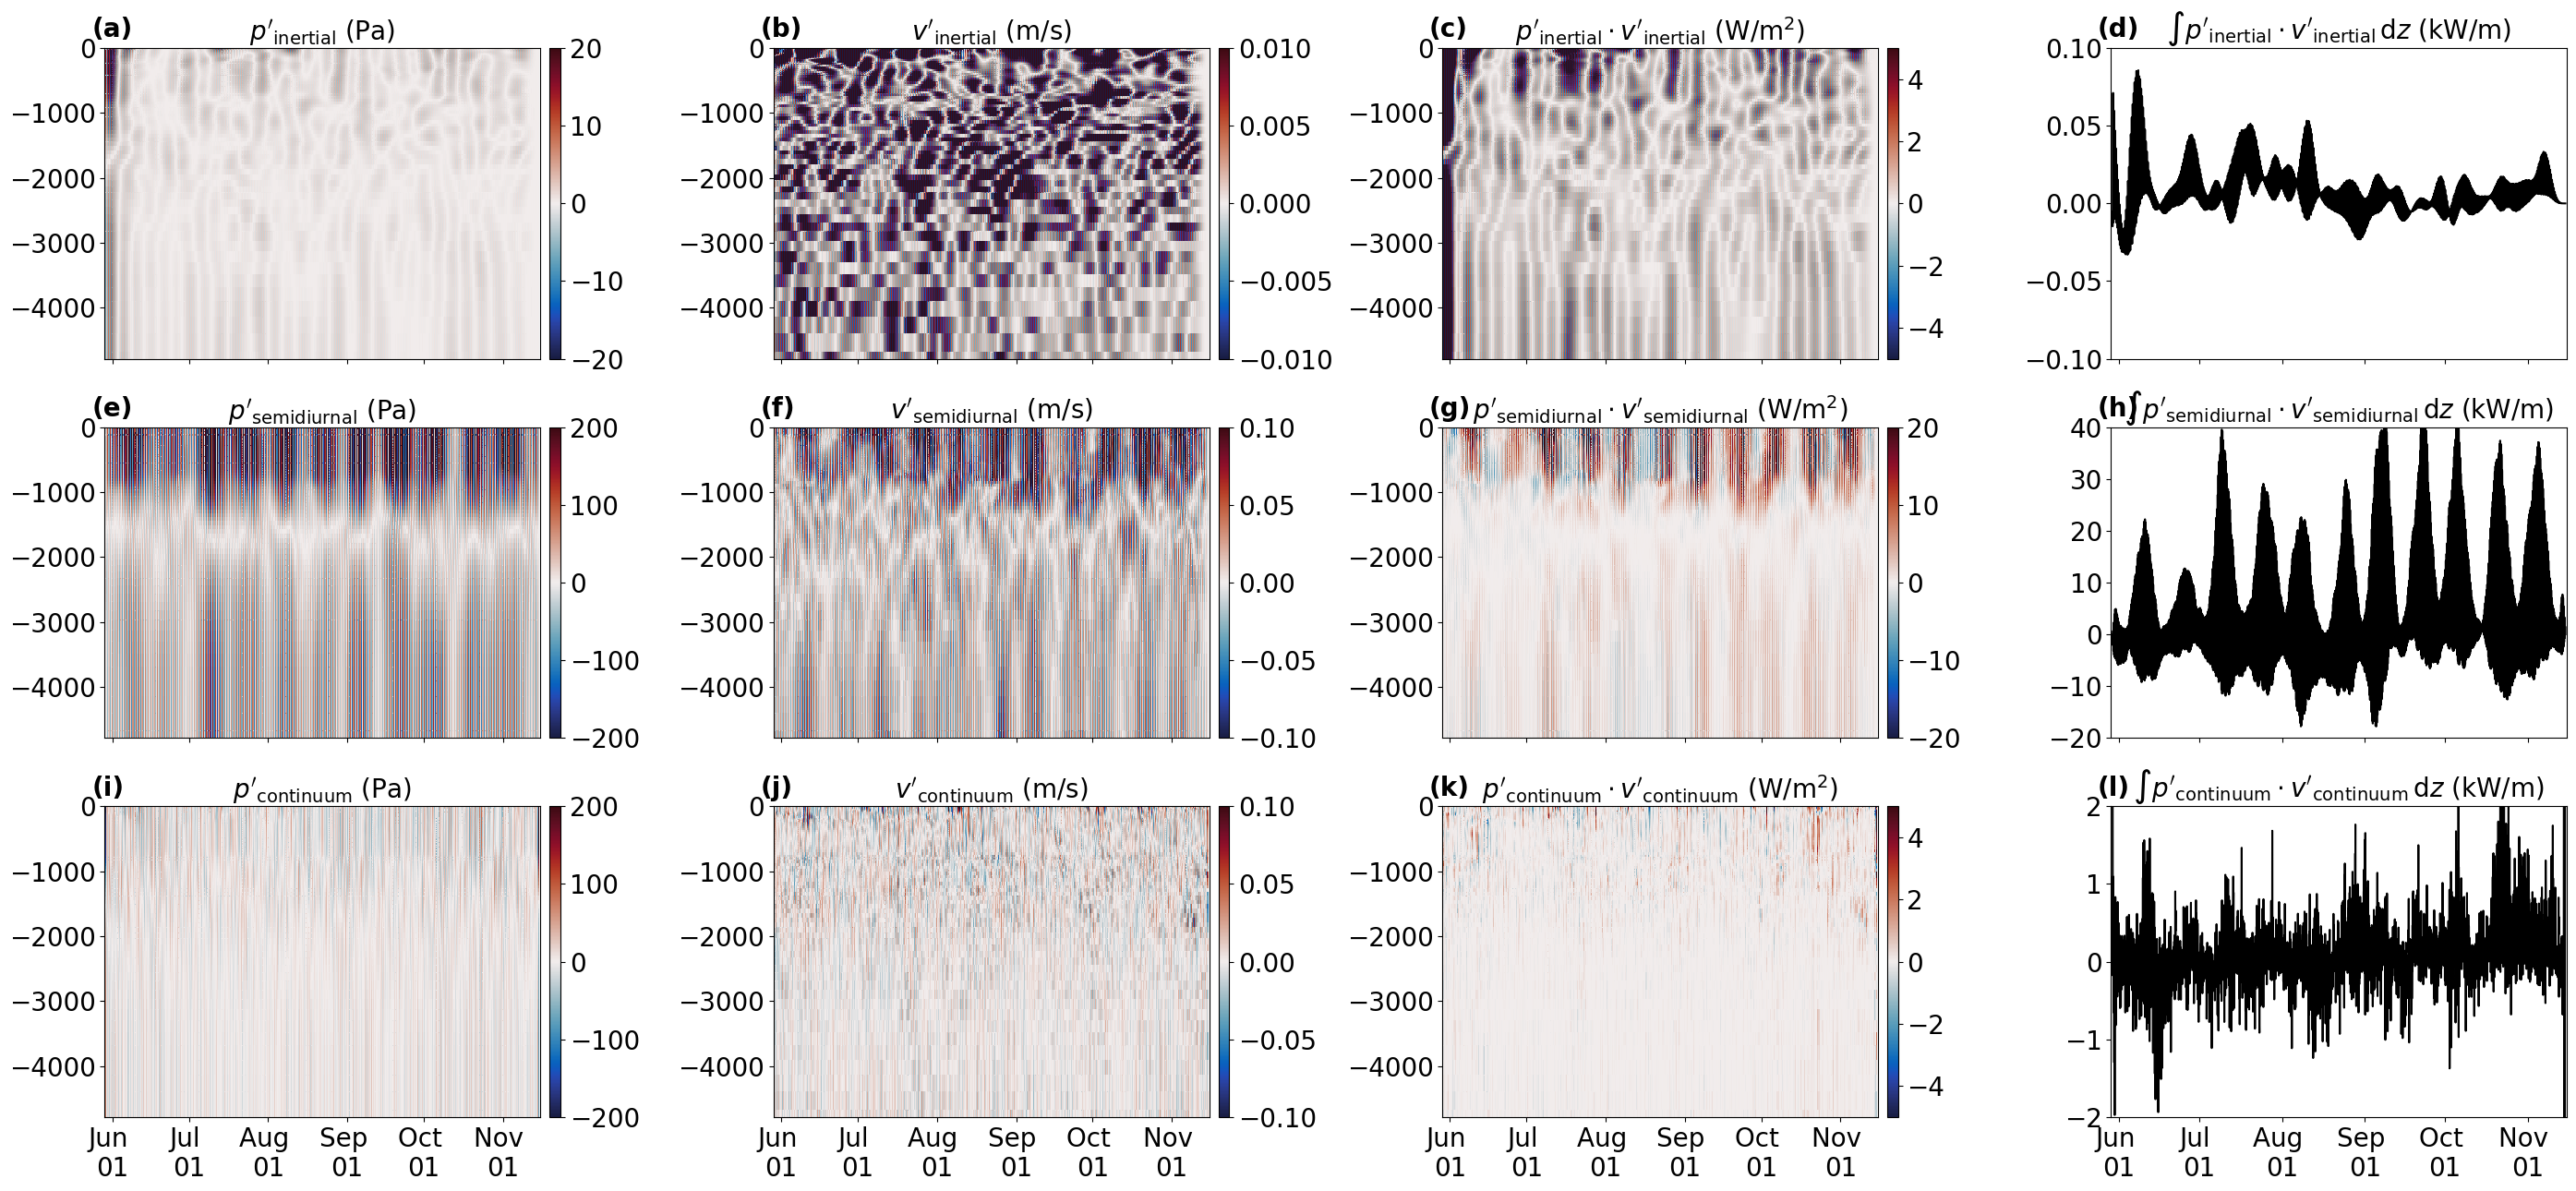

In [14]:
bottom_depth = ds_example_site["bottom_depth"].values.item()
font_size = 20
plim = [[-20, 20],[-200,200],[-200,200]]
vlim = [[-0.01, 0.01],[-0.1,0.1],[-0.1,0.1]]
pvlim = [[-5, 5],[-20,20],[-5,5]]
pvdzlim = [[-0.1,0.1],[-20,40],[-2,2]]

# Create subplots: 4 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(28, 13), sharex=True)
fig.subplots_adjust(left=0.05, right=0.97, bottom=0.15, top=0.95, wspace=0.35, hspace=0.2)
axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b \n%d'))  # Format: 'Jun \n01'

# Manually make the first three columns share the same y-axis
axes[0, 1].sharey(axes[0, 0])
axes[0, 2].sharey(axes[0, 0])
axes[1, 0].sharey(axes[0, 0])
axes[1, 1].sharey(axes[0, 0])
axes[1, 2].sharey(axes[0, 0])
axes[2, 0].sharey(axes[0, 0])
axes[2, 1].sharey(axes[0, 0])
axes[2, 2].sharey(axes[0, 0])

# Set vertical limits for the first three columns
axes[0, 0].set_ylim([-bottom_depth, 0])


from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_colorbar_to_subplot(plot, ax, label, clim, ticks='auto'):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.1)  # Adjust size and padding
    if isinstance(ticks, str) and ticks == 'auto':
        cbar = fig.colorbar(plot, cax=cax)
    else:
        cbar = fig.colorbar(plot, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=font_size)
    
# Data for subplots (example: pressure, velocity, dot products)
subplots = [
    (ds_example_site['pcl_inertial'], axes[0, 0], r"$p'_{\mathrm{inertial}}$ (Pa)", plim[0], 'Pa'),
    (ds_example_site['pcl_m2'], axes[1, 0], r"$p'_{\mathrm{semidiurnal}}$ (Pa)", plim[1], 'Pa'),
    (ds_example_site['pcl_background'], axes[2, 0], r"$p'_{\mathrm{continuum}}$ (Pa)", plim[2], 'Pa'),
    (ds_example_site['vcl_inertial'], axes[0, 1], r"$v'_{\mathrm{inertial}}$ (m/s)", vlim[0], 'm/s'),
    (ds_example_site['vcl_m2'], axes[1, 1], r"$v'_{\mathrm{semidiurnal}}$ (m/s)", vlim[1], 'm/s'),
    (ds_example_site['vcl_background'], axes[2, 1], r"$v'_{\mathrm{continuum}}$ (m/s)", vlim[2], 'm/s'),
    (ds_example_site['pcl_inertial'], axes[0, 2], r"$p'_{\mathrm{inertial}} \cdot v'_{\mathrm{inertial}}$ (W/m$^2$)", pvlim[0], '(W/m²)'),
    ((ds_example_site['pcl_m2'] * ds_example_site['vcl_m2']), axes[1, 2], r"$p'_{\mathrm{semidiurnal}} \cdot v'_{\mathrm{semidiurnal}}$ (W/m$^2$)", pvlim[1], '(W/m²)'),
    ((ds_example_site['pcl_background'] * ds_example_site['vcl_background']), axes[2, 2], r"$p'_{\mathrm{continuum}} \cdot v'_{\mathrm{continuum}}$ (W/m$^2$)", pvlim[2], '(W/m²)')
]


# Loop through subplots and add colorbars
for data, ax, title, clim, label in subplots:
    pc = ax.pcolor(
        ds_example_site['time'].values, ds_example_site['depth'].values,
        np.where(data.T == 0, np.nan, data.T),
        cmap='cmo.balance', vmin=clim[0], vmax=clim[1], shading='auto'
    )
    ax.set_title(title, fontsize=font_size)
    ticks = 'auto'
    add_colorbar_to_subplot(pc, ax, label, clim, ticks=ticks)

# Data for line plots (fourth column)
line_plots = [
    (ds_example_site['Ecl_inertial'], axes[0, 3], r"$\int p'_{\mathrm{inertial}} \cdot v'_{\mathrm{inertial}}\, \mathrm{d}z$ (kW/m)","(kW/m)"),
    (ds_example_site['Ecl_m2'], axes[1, 3], r"$\int p'_{\mathrm{semidiurnal}} \cdot v'_{\mathrm{semidiurnal}}\, \mathrm{d}z$ (kW/m)","(kW/m)"),
    (ds_example_site['Ecl_continuum'], axes[2, 3], r"$\int p'_{\mathrm{continuum}} \cdot v'_{\mathrm{continuum}}\, \mathrm{d}z$ (kW/m)","(kW/m)")
]

# Loop through line plots
for data, ax, title, ylabel in line_plots:
    ax.plot(
        ds_example_site['time'].values,
        np.where(data == 0, np.nan, data / 1000),  # Convert to kW/m
        color='k'
    )
    ax.set_title(title, fontsize=font_size)
    # ax.set_ylabel(ylabel, fontsize=font_size)
    
# Update tick label sizes
for ax_row in axes:
    for ax in ax_row:
        ax.tick_params(axis='both', which='major', labelsize=font_size)

panel_labels = ['(a)', '(b)', '(c)', '(d)',
                '(e)', '(f)', '(g)', '(h)',
                '(i)', '(j)', '(k)', '(l)']
label_idx = 0
for row in range(3):
    for col in range(4):
        axes[row, col].text(-0.03, 1.1, panel_labels[label_idx],
                            transform=axes[row, col].transAxes,
                            fontsize=font_size, fontweight='bold',
                            va='top', ha='left')
        label_idx += 1


# axes[0, 3].set_yticks(np.arange(-0.1, 0.11, 10))
axes[0, 3].set_ylim(pvdzlim[0][0], pvdzlim[0][1])

# axes[1, 3].set_yticks(np.arange(-20, 41, 10))
axes[1, 3].set_ylim(pvdzlim[1][0], pvdzlim[1][1])

# axes[2, 3].set_yticks(np.arange(-2, 2.5, 0.5))
axes[2, 3].set_ylim(pvdzlim[2][0], pvdzlim[2][1])



plt.tight_layout()
plt.show()


### Figure 4

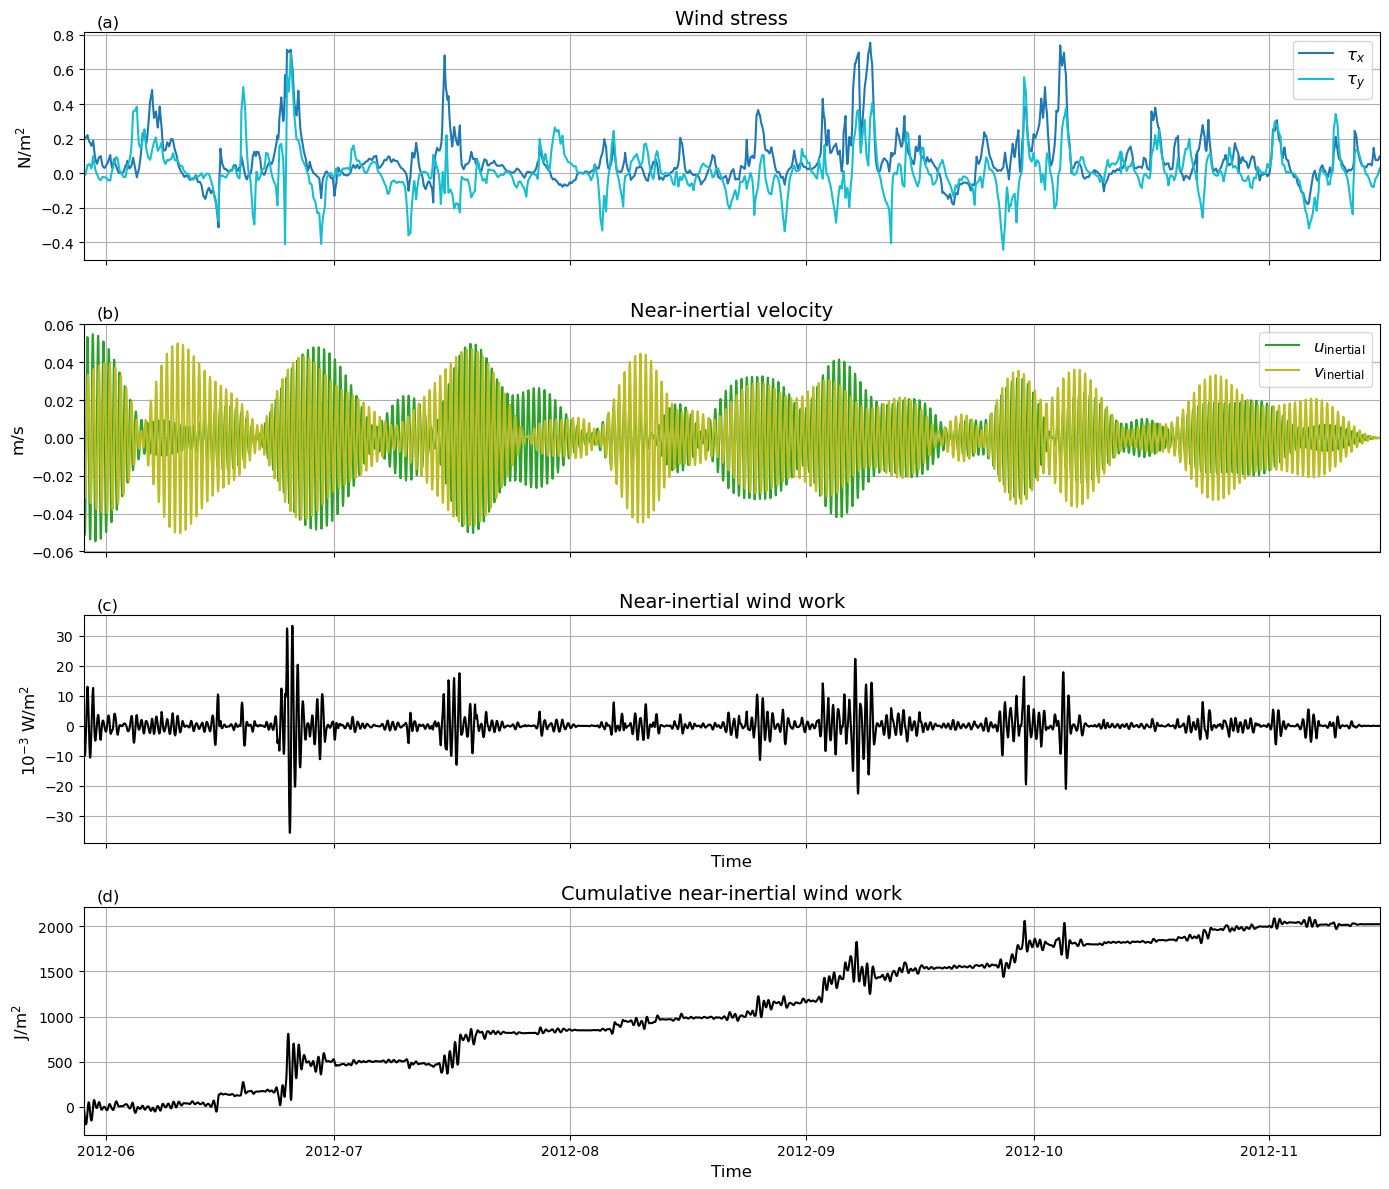

In [15]:
dt = 3600  # 1 hour in seconds
niw_cumsum = np.cumsum(ds_site_bandpass['niw'].squeeze().values * dt)

ds_site = ds_site_bandpass.copy()

fontsize_title = 14
fontsize_label = 12
fontsize_tick = 12

# Create 3 vertically stacked subplots sharing x-axis
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)



# Panel 1: Wind stress
axes[0].plot(ds_site['time'], ds_site['taux'].squeeze(), label=r'$\tau_x$', color='tab:blue')
axes[0].plot(ds_site['time'], ds_site['tauy'].squeeze(), label=r'$\tau_y$', color='tab:cyan')
axes[0].set_ylabel('N/m$^2$', fontsize=fontsize_label)
axes[0].set_title('Wind stress', fontsize=fontsize_title)
axes[0].legend(loc='upper right', fontsize=fontsize_label)
axes[0].grid(True)
axes[0].set_xlim(ds_site['time'][0].values, ds_site['time'][-1].values)

# Panel 2: Slab velocities
axes[1].plot(ds_site['time'], ds_site['Z_real'].squeeze(), label=r'$u_{\mathrm{inertial}}$', color='tab:green')
axes[1].plot(ds_site['time'], ds_site['Z_imag'].squeeze(), label=r'$v_{\mathrm{inertial}}$', color='tab:olive')
axes[1].set_ylabel('m/s', fontsize=fontsize_label)
axes[1].set_title('Near-inertial velocity', fontsize=fontsize_title)
axes[1].legend(loc='upper right', fontsize=fontsize_label)
axes[1].grid(True)

# Panel 3: NIW Work
axes[2].plot(ds_site['time'], 1e3 * ds_site['niw'].squeeze(), label='Near-inertial Wind Work', color='k')
axes[2].set_ylabel(r'$10^{-3}$ W/m$^2$', fontsize=fontsize_label)
axes[2].set_title('Near-inertial wind work', fontsize=fontsize_title)
axes[2].set_xlabel('Time', fontsize=fontsize_label)
# axes[2].legend(loc='upper right', fontsize=fontsize_label)
axes[2].grid(True)

# Panel 4: Cumulative Energy Input
axes[3].plot(ds_site['time'], niw_cumsum, label='Cumulative NIW Work', color='k')
axes[3].set_ylabel('J/m$^2$', fontsize=fontsize_label)
axes[3].set_title('Cumulative near-inertial wind work', fontsize=fontsize_title)
axes[3].set_xlabel('Time', fontsize=fontsize_label)
# axes[3].legend(loc='center right', fontsize=fontsize_label)
axes[3].grid(True)

panel_labels = ['(a)', '(b)', '(c)', '(d)']

for ax, label in zip(axes, panel_labels):
    ax.text(0.01, 1.08, label, transform=ax.transAxes,
            fontsize=fontsize_label, va='top')

plt.tight_layout()
plt.show()


### Figure 5, 6, 7, 8

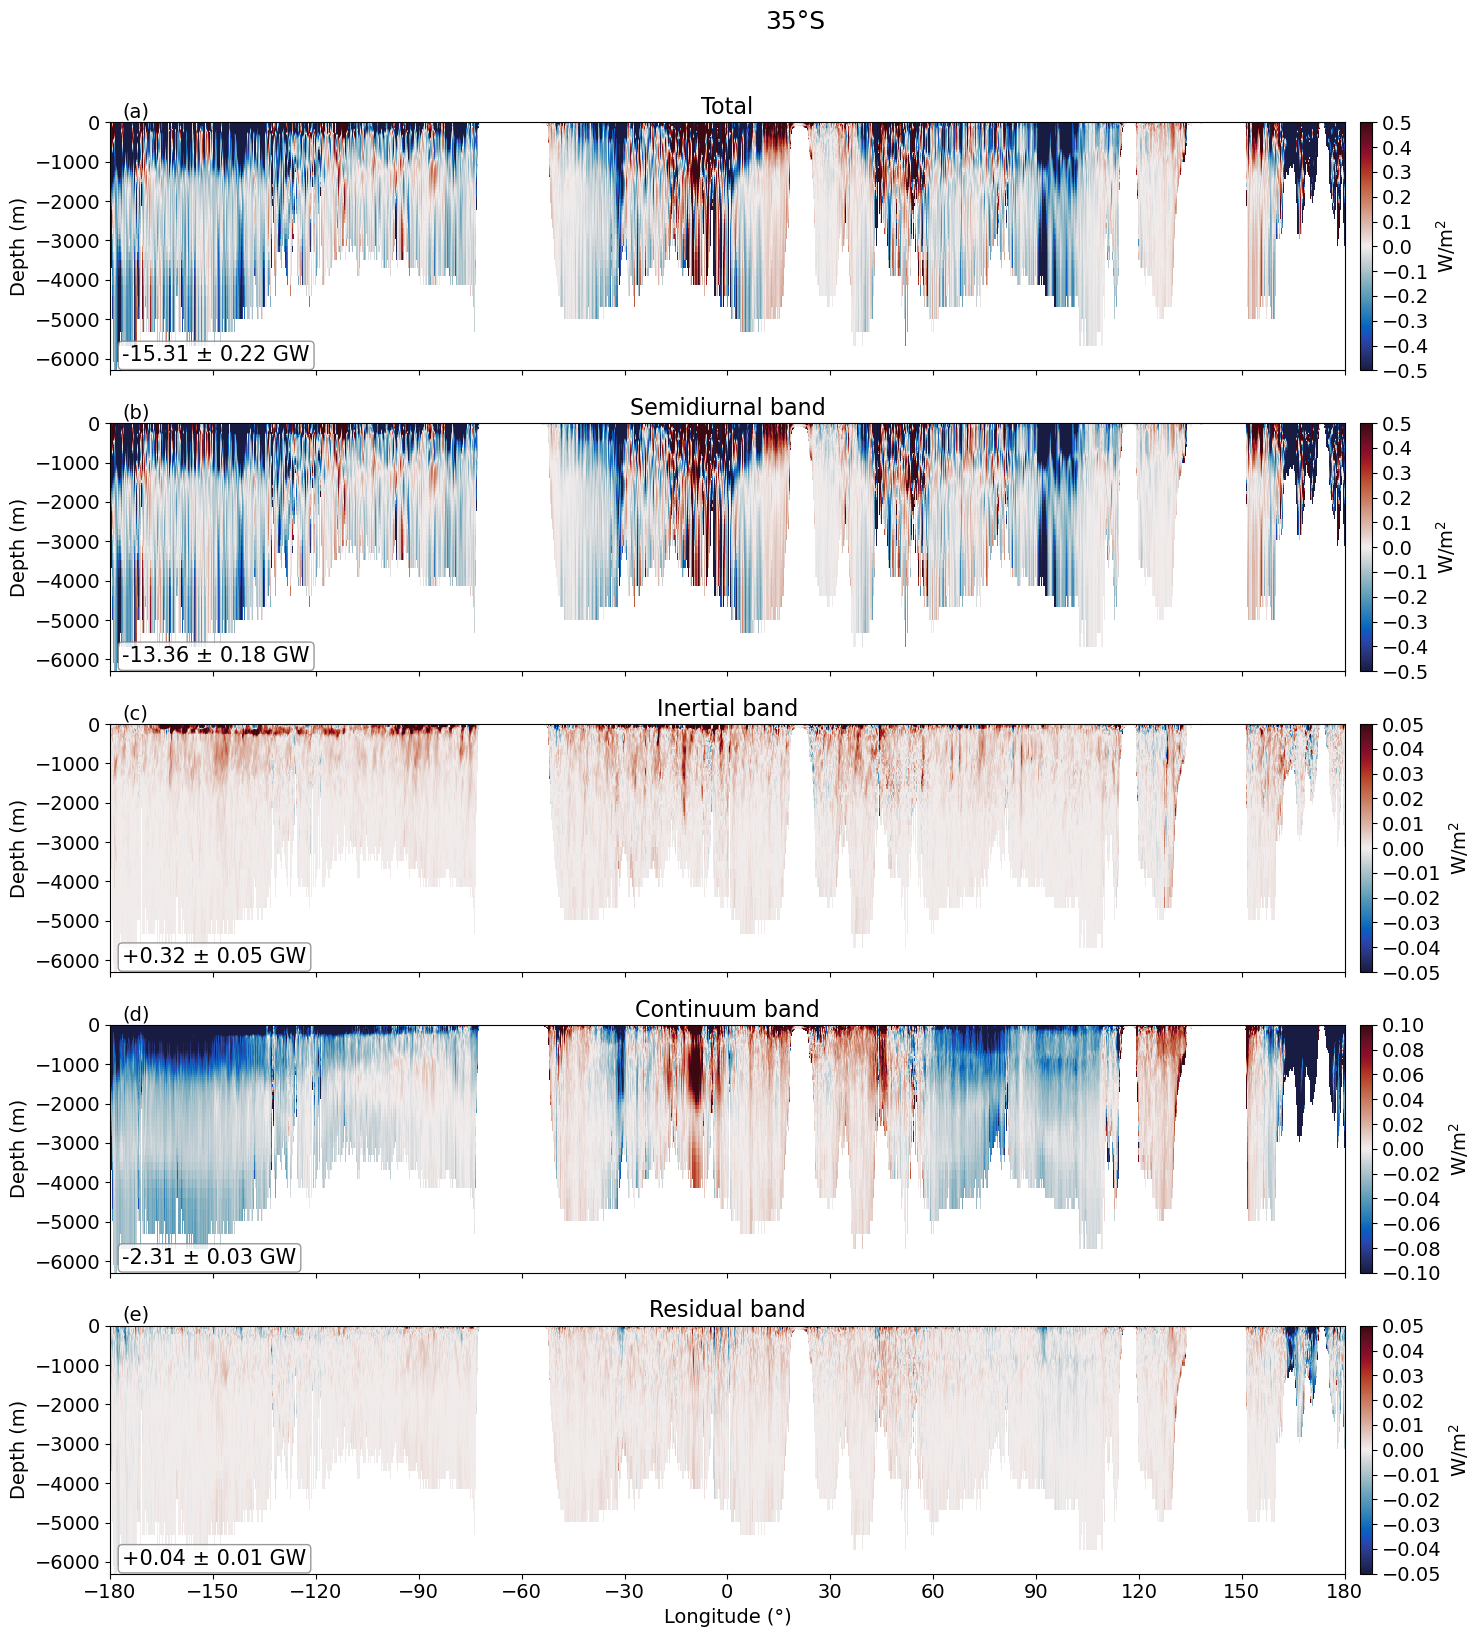

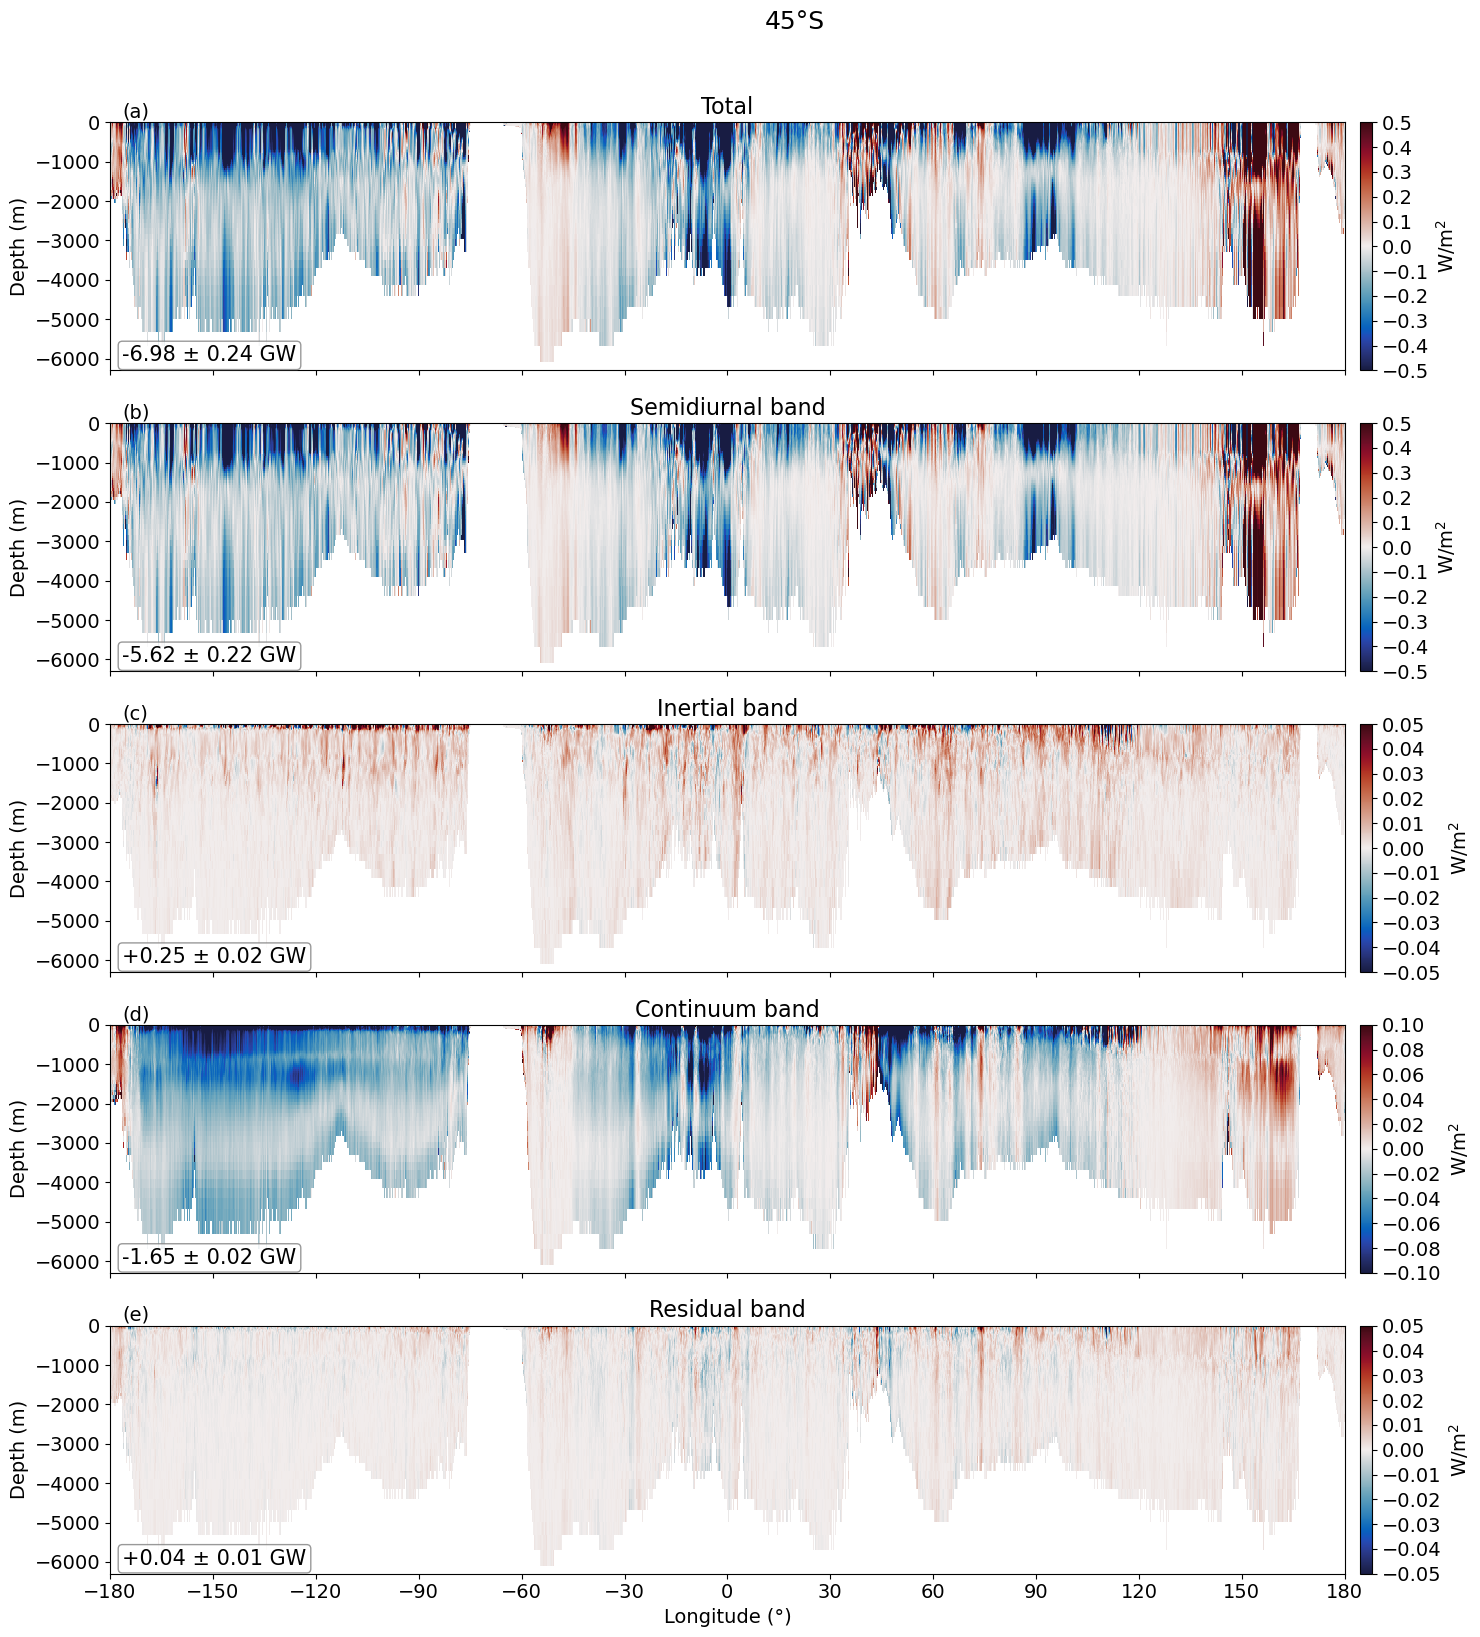

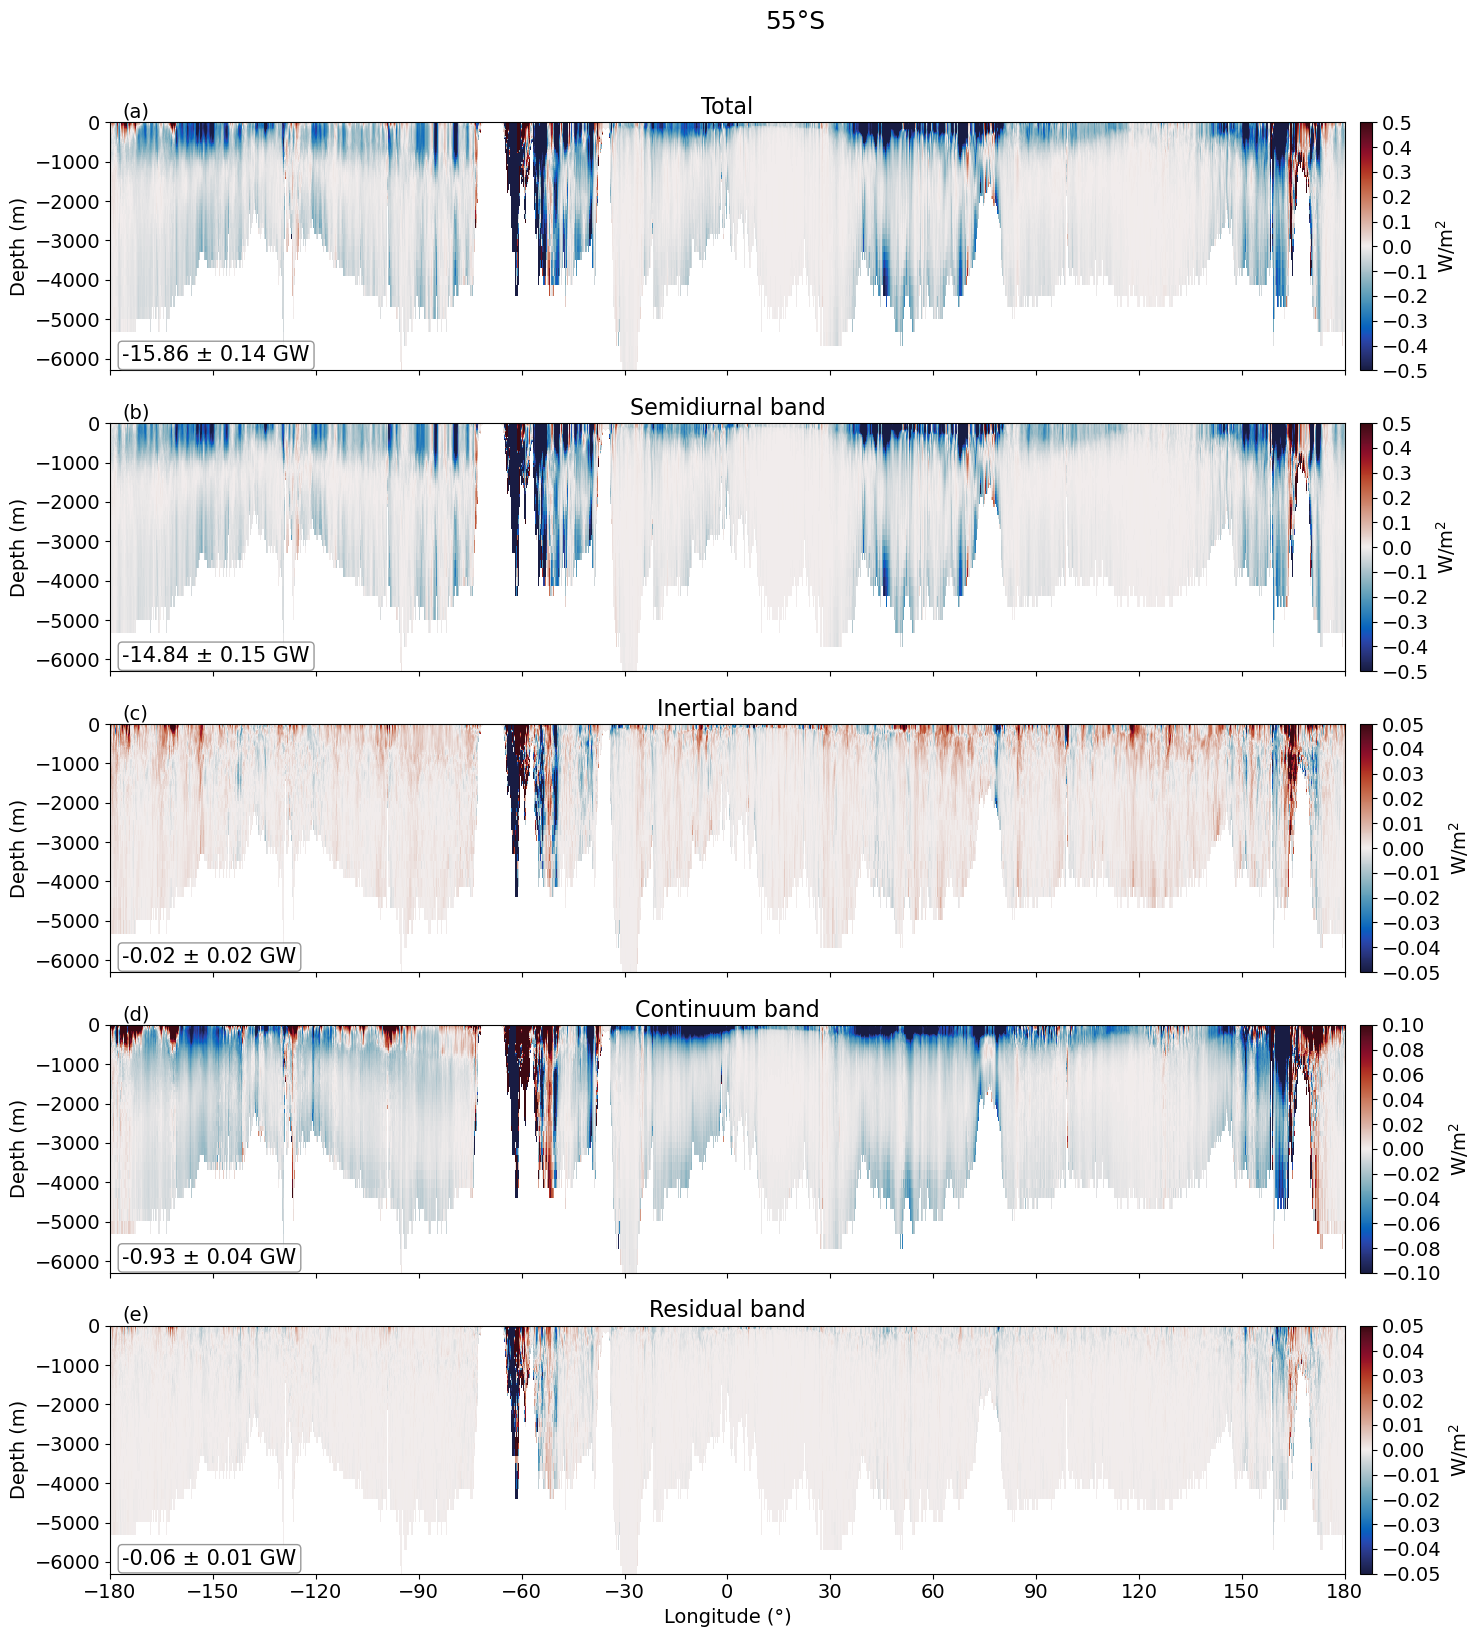

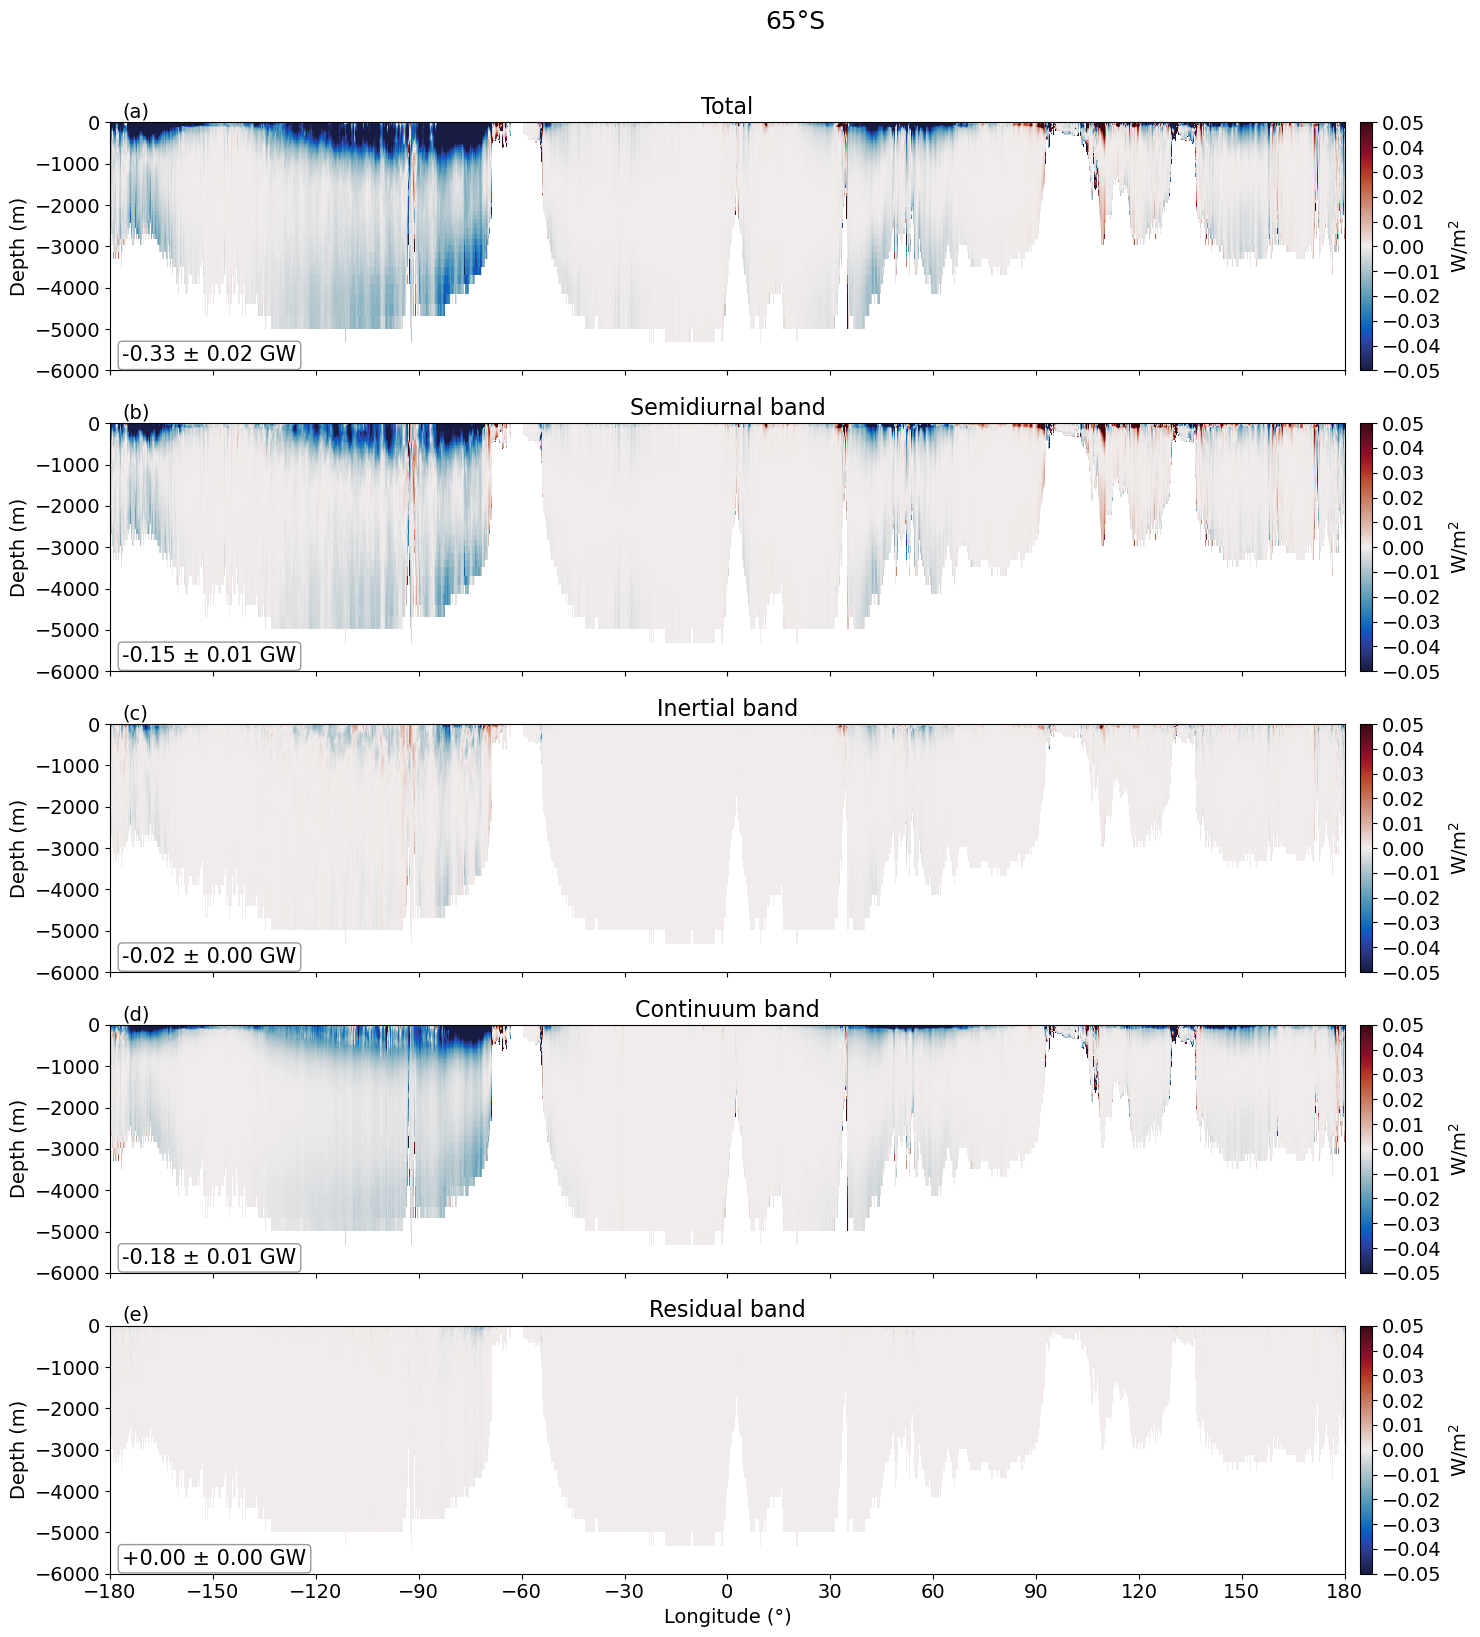

In [16]:
datasets = {
    -35: ds_flux_mean_sorted_35S,
    -45: ds_flux_mean_sorted_45S,
    -55: ds_flux_mean_sorted_55S,
    -65: ds_flux_mean_sorted_65S,
}

for lat, ds_flux_mean_sorted in datasets.items():

    # Color limits and ticks
    if lat in [-35, -45, -55]:
        clim = [[-0.5, 0.5], [-0.5, 0.5], [-0.05, 0.05], [-0.1, 0.1], [-0.05, 0.05]]
        cticks = [
            np.arange(-0.5, 0.6, 0.1),
            np.arange(-0.5, 0.6, 0.1),
            np.arange(-0.05, 0.06, 0.01),
            np.arange(-0.1, 0.11, 0.02),
            np.arange(-0.05, 0.06, 0.01),
        ]
    elif lat == -65:
        clim = [[-0.05, 0.05]] * 5
        cticks = [np.arange(-0.05, 0.06, 0.01)] * 5

    # Text annotations and limits
    if lat == -35:
        mmean = [-15.31,-13.36,0.32,-2.31,0.04]
        merr = [0.22, 0.18, 0.05, 0.03, 0.01]
        ylim = [-6300, 0]
    elif lat == -45:
        mmean = [-6.98,-5.62,0.25,-1.65,0.04]
        merr = [0.24, 0.22, 0.02, 0.02, 0.01]
        ylim = [-6300, 0]
    elif lat == -55:
        mmean = [-15.86,-14.84,-0.02,-0.93,-0.06]
        merr = [0.14, 0.15, 0.02, 0.04, 0.01]
        ylim = [-6300, 0]
    elif lat == -65:
        mmean = [-0.33,-0.15,-0.02,-0.18,0.00]
        merr = [0.02, 0.01, 0.00, 0.01, 0.00]
        ylim = [-6000, 0]
    
    # Font settings
    fontsize_title = 16
    fontsize_label = 14
    fontsize_tick = 14
    fontsize_cbar_label = fontsize_label
    fontsize_cbar_tick = fontsize_tick

    titles = ["Total", "Semidiurnal band", "Inertial band", "Continuum band", "Residual band"]
    vars_to_plot = ['EclH_mean', 'Ecl_m2_mean','Ecl_inertial_mean', 'Ecl_background_mean', 'Ecl_residual_mean']
    panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']

    lon_1d = ds_flux_mean_sorted['lon'].squeeze().values
    depth_1d = ds_flux_mean_sorted['depth'].values

    fig, axes = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

    for i, ax in enumerate(axes):
        pcm = ax.pcolormesh(
            lon_1d, depth_1d,
            ds_flux_mean_sorted[vars_to_plot[i]].squeeze().T,
            shading='auto', cmap='cmo.balance',
            vmin=clim[i][0], vmax=clim[i][1]
        )

        cbar = fig.colorbar(pcm, ax=ax, label=r"W/m$^2$", pad=0.01)
        cbar.set_label(r"W/m$^2$", fontsize=fontsize_cbar_label)
        cbar.set_ticks(cticks[i])
        cbar.ax.tick_params(labelsize=fontsize_cbar_tick)

        ax.set_title(titles[i], fontsize=fontsize_title)
        ax.set_ylim(ylim)
        ax.set_ylabel('Depth (m)', fontsize=fontsize_label)
        ax.tick_params(labelsize=fontsize_tick)
        ax.text(0.01, 1.08, panel_labels[i], transform=ax.transAxes, fontsize=fontsize_label, va='top', ha='left')
        ax.text(
            0.01, 0.02,
            f"{mmean[i]:+.2f} ± {merr[i]:.2f} GW",
            transform=ax.transAxes, fontsize=15,
            va='bottom', ha='left',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='gray', alpha=0.8)
        )

        ax.set_xticks(np.arange(-180, 181, 30))
        ax.set_yticks(np.arange(0, -7000, -1000))

    axes[-1].set_xlabel('Longitude (°)', fontsize=fontsize_label)
    fig.suptitle(f"{int(abs(lat))}°S", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()


### Figure 9

In [17]:
# Replace 0 with NaN 
sorted_datasets = [ds_Edz_35S_sorted, ds_Edz_45S_sorted, ds_Edz_55S_sorted, ds_Edz_65S_sorted]
for i in range(len(sorted_datasets)):
    for var in sorted_datasets[i].data_vars:
        if np.issubdtype(sorted_datasets[i][var].dtype, np.number):
            sorted_datasets[i][var] = sorted_datasets[i][var].where(sorted_datasets[i][var] != 0)
ds_Edz_35S_sorted_nonnan, ds_Edz_45S_sorted_nonnan, ds_Edz_55S_sorted_nonnan, ds_Edz_65S_sorted_nonnan = sorted_datasets


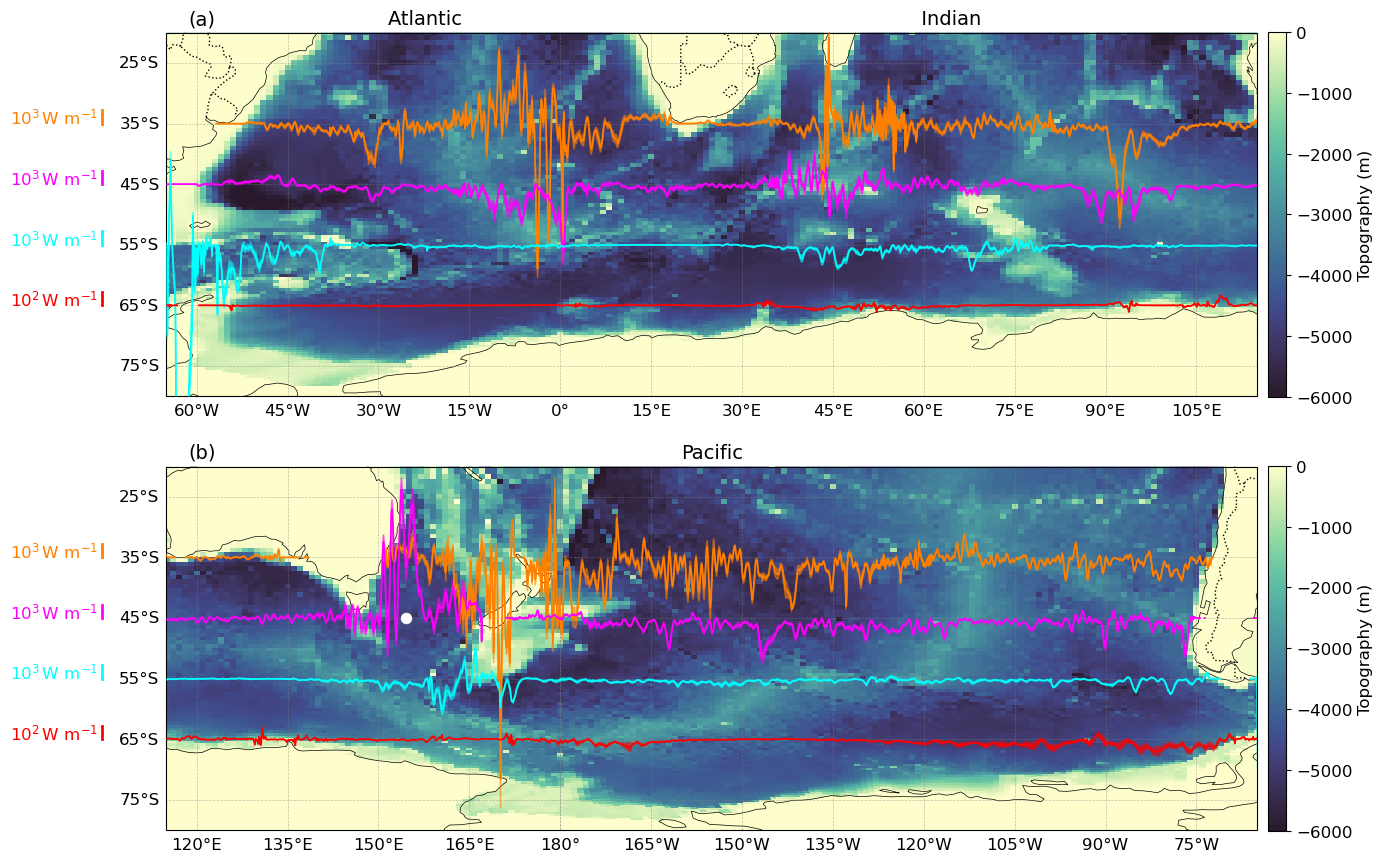

In [18]:
background, vmin, vmax, cmap  = 'bottom_depth', -6000, 0, cmocean.cm.deep_r
# ------------------------------------------------------------------
#  CONSTANTS / INPUTS ----------------------------------------------
# ------------------------------------------------------------------
latitudes   = [-35, -45, -55, -65]
datasets    = [ds_Edz_35S_sorted_nonnan, ds_Edz_45S_sorted_nonnan, ds_Edz_55S_sorted_nonnan, ds_Edz_65S_sorted_nonnan]
colors      = ['#ff8000', '#ff00ff', 'cyan', 'red']
scales      = [1e3, 1e3, 1e3, 1e2]
labels_txt  = [r'$10^3\,$W m$^{-1}$', r'$10^3\,$W m$^{-1}$', r'$10^3\,$W m$^{-1}$', r'$10^2\,$W m$^{-1}$']
plot_scale  = 2.2
desired_lats= [-25, -35, -45, -55, -65, -75]
x_frac_bar  = 0.16                    # bar position in figure-fraction

# ------------------------------------------------------------------
#  FIGURE & 2 SUBPLOTS ---------------------------------------------
# ------------------------------------------------------------------
fig = plt.figure(figsize=(16, 11))
ax1 = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=180))
fig.subplots_adjust(left=0.20, hspace=0.05)

def plot_panel(ax, extent, central_lon, ticks):
    # ------------ background --------------------------------------
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    d = 48 # you can coarsen the bathyemery resolution to 
    p = ax.pcolormesh(ds_grid['lon'].values[::d, ::d],
                      ds_grid['lat'].values[::d, ::d],
                      -ds_grid['bottom_depth'][::d, ::d],
                      shading='auto', cmap=cmap, vmin = vmin, vmax = vmax, transform=ccrs.PlateCarree())
    
    # ------------ flux lines --------------------------------------
    for lat, ds, col, scl in zip(latitudes, datasets, colors, scales):
        flux = plot_scale * (ds['Ecl_m2_dz_mean'] / scl).values.squeeze()
        flux_std = plot_scale * (ds['Ecl_m2_dz_monthly_error'] / scl).values.squeeze()
        lon = ds['lon'].values
        ax.plot(lon, lat + flux, color=col, lw=1.2,transform=ccrs.PlateCarree(), zorder=4)

        # shading zones
        upper = lat + flux + flux_std
        lower = lat + flux - flux_std
        ax.fill(
            np.concatenate([lon, lon[::-1]]),
            np.concatenate([upper, lower[::-1]]),
            color=col, alpha=0.5, transform=ccrs.PlateCarree(), zorder=3
        )
        
    # ------------ reference bars & labels ------------------------
    trans = mtransforms.blended_transform_factory(fig.transFigure,ax.transData)
    for lat, col, lab in zip(latitudes, colors, labels_txt):
        # bar
        fig.add_artist(mlines.Line2D([x_frac_bar, x_frac_bar],
                                     [lat, lat + plot_scale],
                                     transform=trans,
                                     color=col, lw=2, zorder=5))
        # label
        ax.annotate(lab, xy=(x_frac_bar, lat + 0.5*plot_scale), xycoords=trans, xytext=(-3, 0), textcoords='offset points', ha='right', va='center',color=col, fontsize=12, clip_on=False, zorder=6)

    # ------------ map --------------------------------
    ax.add_feature(cfeature.COASTLINE, lw=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.right_labels   = False  
    gl.top_labels    = False   
    gl.xlabel_style  = {'size': 12}
    gl.ylabel_style  = {'size': 12}
    desired_lats = [-25,-35, -45, -55, -65,-75]
    gl.ylocator  = mticker.FixedLocator(desired_lats)
    gl.xlocator = MultipleLocator(15)
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    cbar = plt.colorbar(p, ax=ax, orientation='vertical',pad=0.01, fraction=0.0163,label='Topography (m)')
    cbar.set_label('Topography (m)', fontsize=12)          
    cbar.ax.tick_params(labelsize=12)    
    
# ------------------------------------------------------------------
#  DRAW PANELS ------------------------------------------------------
# ------------------------------------------------------------------
plot_panel(ax1, [-65, 115, -80, -20], central_lon = 0,   ticks=np.arange(-6000, 1, 1000))   
plot_panel(ax2, [115, 295, -80, -20], central_lon = 180, ticks=np.arange(-6000, 1, 1000))  

# --- add reference dot at 154.5°E, 45°S ---------------------------
ax2.scatter(154.5, -45, s=60, marker='o', color='white', edgecolor='white', linewidth=0.5, zorder=6, transform=ccrs.PlateCarree())   

ax1.text(0.02, 1.065, '(a)', transform=ax1.transAxes, fontsize=14, va='top')
ax2.text(0.02, 1.065, '(b)', transform=ax2.transAxes, fontsize=14, va='top')

# ------------------------------------------------------------------
#  TITLES -----------------------------------------------------------
# ------------------------------------------------------------------
ax1.set_title('Atlantic                                                                           Indian         ', fontsize=14)
ax2.set_title('Pacific', fontsize=14)
plt.show()


### Figure 10

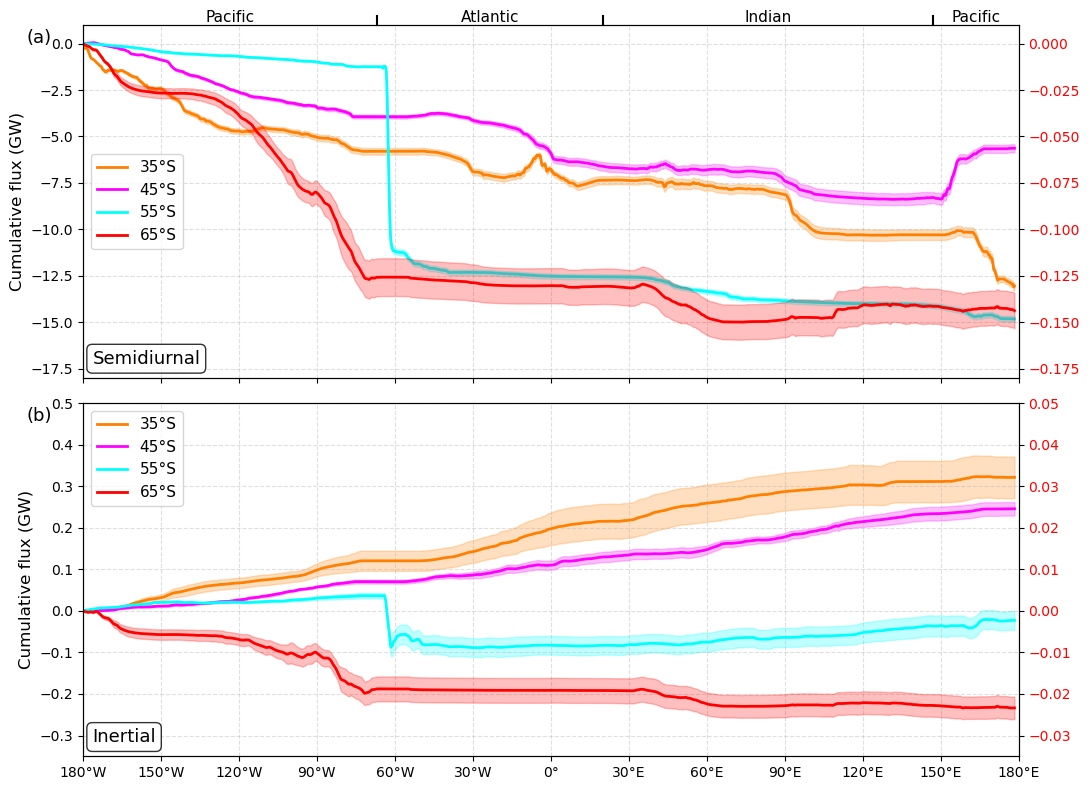

In [19]:
datasets = {
    '35S': ds_cumulative_35S,
    '45S': ds_cumulative_45S,
    '55S': ds_cumulative_55S,
    '65S': ds_cumulative_65S,
}
colors_m2       = ['#ff8000', '#ff00ff', 'cyan', 'red']
colors_inertial = ['#ff8000', '#ff00ff', 'cyan', 'red']

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 8),sharex = True)
fig.subplots_adjust(hspace=0.15)

# -------------------------------------------
# PANEL (a): SEMIDIURNAL FLUX
# -------------------------------------------
for (label, ds), col in zip(datasets.items(), colors_m2):
    if label == '65S':    # 65°S plotted separately with scaling  
        continue
    lon = ds['lon'].squeeze().values                               # (x,)
    cum_mean = ds['Ecl_m2_cumulative_mean'].squeeze() / 1e9        # Convert to GW
    cum_std  = ds['Ecl_m2_cumulative_monthly_error'].squeeze() / 1e9

    # ----------------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------------
    ax1.plot(lon, cum_mean, color=col, lw=2, label=label, linestyle='-')
    ax1.fill_between(lon, cum_mean - cum_std, cum_mean + cum_std, color=col, alpha=0.25)
    ax1.set_ylim([-18,1])

ax1.text(0.01, 0.08, 'Semidiurnal', transform=ax1.transAxes, ha='left', va='top', fontsize=13, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax1.xaxis.set_major_locator(MultipleLocator(30))
ax1.set_xlim([-180,180])
ax1.set_ylabel('Cumulative flux (GW)', fontsize=12)
ax1.grid(True, ls='--', alpha=0.4)
ax1.legend(fontsize=11, loc='center left')

# -------------------------------------------
# PANEL (b): INERTIAL FLUX
# -------------------------------------------
for (label, ds), col in zip(datasets.items(), colors_inertial):
    if label == '65S':  # 65°S plotted separately with scaling    
        continue
    lon = ds['lon'].squeeze().values
    cum_mean = ds['Ecl_inertial_cumulative_mean'].squeeze() / 1e9        # Convert to GW
    cum_std  = ds['Ecl_inertial_cumulative_monthly_error'].squeeze() / 1e9
    # ----------------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------------    
    ax2.plot(lon, cum_mean, color=col, lw=2, label=label)
    ax2.fill_between(lon, cum_mean - cum_std, cum_mean + cum_std, color=col, alpha=0.25)

ax2.set_xlim([-180,180])
ax2.set_ylabel('Cumulative flux (GW)', fontsize=12)
ax2.set_ylim([-0.35,0.5])
ax2.grid(True, ls='--', alpha=0.4)
ax2.legend(fontsize=11, loc='center left')
ax2.text(0.01, 0.08, 'Inertial', transform=ax2.transAxes, ha='left', va='top', fontsize=13, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax1.text(-0.06, 0.95, '(a)', transform=ax1.transAxes, fontsize=13)
ax2.text(-0.06, 0.95, '(b)', transform=ax2.transAxes, fontsize=13)

xticks = np.arange(-180, 181, 30)
xtick_labels = [f'{abs(x)}°W' if x < 0 else (f'{x}°E' if x > 0 else '0°') for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xtick_labels, fontsize=11)



# -------------------------------------------
# PLOT 65°S LINES ON RIGHT Y-AXES
# -------------------------------------------

# Panel (a): 65°S semidiurnal (scaled ×100)
ax1r = ax1.twinx()
ds = datasets['65S']
lon = ds['lon'].squeeze().values
cum_mean = ds['Ecl_m2_cumulative_mean'].squeeze() / 1e9        # Convert to GW
cum_std  = ds['Ecl_m2_cumulative_monthly_error'].squeeze() / 1e9
ax1r.plot(lon, cum_mean , color='red', lw=2, linestyle='-', label='65°S (scaled)')
ax1r.fill_between(lon, (cum_mean - cum_std) , (cum_mean + cum_std) , color='red', alpha=0.25)
ax1r.tick_params(axis='y', labelcolor='red', labelsize=10)

scale = 0.01 
ylim_left = ax1.get_ylim()        
ax1r.set_ylim(ylim_left[0] * scale, ylim_left[1] * scale)


# Panel (b): 65°S inertial (scaled ×10)
ax2r = ax2.twinx()
cum_mean = ds['Ecl_inertial_cumulative_mean'].squeeze() / 1e9        # Convert to GW
cum_std  = ds['Ecl_inertial_cumulative_monthly_error'].squeeze() / 1e9
ax2r.plot(lon, cum_mean , color='red', lw=2, linestyle='-', label='65°S (scaled)')
ax2r.fill_between(lon, (cum_mean - cum_std), (cum_mean + cum_std), color='red', alpha=0.25)
ax2r.tick_params(axis='y', labelcolor='red', labelsize=10)

scale = 0.1
ylim_left = ax2.get_ylim()       
ax2r.set_ylim(ylim_left[0] * scale, ylim_left[1] * scale)

# -------------------------------------------
# CUSTOM LONGITUDE REGION LABELS
# -------------------------------------------
bracket_bottom = 1
bracket_top    = 1.5
text_y         = 1
ax1.plot([-67, -67], [bracket_bottom, bracket_top], color='k', lw=1.5, clip_on=False)
ax1.plot([20, 20], [bracket_bottom, bracket_top], color='k', lw=1.5, clip_on=False)
ax1.plot([147, 147], [bracket_bottom, bracket_top], color='k', lw=1.5, clip_on=False)
ax1.text((-180 + -67) / 2, text_y, 'Pacific', ha='center', va='bottom', fontsize=11, color='k')
ax1.text((-67 + 20) / 2, text_y, 'Atlantic', ha='center', va='bottom', fontsize=11, color='k')
ax1.text((20 + 147) / 2, text_y, 'Indian', ha='center', va='bottom', fontsize=11, color='k')
ax1.text((147 + 180) / 2, text_y, 'Pacific', ha='center', va='bottom', fontsize=11, color='k')


# legends
labels_all = ['35°S', '45°S', '55°S', '65°S'] 

handles1, labels1 = ax1.get_legend_handles_labels()
handles1r, labels1r = ax1r.get_legend_handles_labels()
handles_all = handles1 + handles1r 
ax1.legend(handles_all, labels_all, fontsize=11, loc='center left')

handles2, labels2 = ax2.get_legend_handles_labels()
handles2r, labels2r = ax2r.get_legend_handles_labels()
handles_all = handles2 + handles2r 
ax2.legend(handles_all, labels_all, fontsize=11, loc='upper left')

y_min, y_max = ax1.get_ylim()
y_range = y_max - y_min


plt.tight_layout()
plt.show()

### Figure 11

Row-wise shift to fix longitude discontinuity at the dateline.  
Without this, near-inertial wind power maps can appear distorted.  
Skip this if accurate mapping isn't needed.

In [20]:
def rowwise_lon180(lon2d, lat2d, data2d):
    """
    Fix the longitude seam in 2D fields row by row and convert longitudes to the [-180, 180] range.
    """
    lon_out = np.empty_like(lon2d)
    lat_out = np.empty_like(lat2d)
    dat_out = np.empty_like(data2d)

    for j in range(lon2d.shape[1]):
        lon_row = lon2d[:, j].copy()
        lat_row = lat2d[:, j].copy()
        dat_row = data2d[:, j].copy()

        jump = np.where(np.diff(lon_row) < -180)[0]
        seam = int(jump[0] + 1) if jump.size else 0

        lon_row = np.roll(lon_row, -seam)
        lat_row = np.roll(lat_row, -seam)
        dat_row = np.roll(dat_row, -seam)

        lon_row = ((lon_row + 180) % 360) - 180

        lon_out[:, j] = lon_row
        lat_out[:, j] = lat_row
        dat_out[:, j] = dat_row

    return lon_out, lat_out, dat_out


def fix_all_2D_vars_rowwise_lon180(ds):
    """
    Apply row-wise seam fixing and longitude conversion to [-180, 180]
    for all 2D (x, y) variables in the dataset.
    """
    lon = ds['lon'].values
    lat = ds['lat'].values
    lon_fixed, lat_fixed, _ = rowwise_lon180(lon, lat, np.zeros_like(lon))

    new_vars = {
        'lon': (('x', 'y'), lon_fixed),
        'lat': (('x', 'y'), lat_fixed)
    }

    for varname, da in ds.data_vars.items():
        if da.dims == ('x', 'y'):
            _, _, data_fixed = rowwise_lon180(lon, lat, da.values)
            new_vars[varname] = (('x', 'y'), data_fixed)
        else:
            new_vars[varname] = da  # retain unchanged

    ds_new = xr.Dataset(
        data_vars=new_vars,
        coords={dim: ds.coords[dim] for dim in ds.dims if dim not in ['x', 'y']}
    ).assign_coords({'x': ds['x'], 'y': ds['y']})

    return ds_new


def rowwise_lon360(lon2d, lat2d, data2d):
    """
    Sort each row (j) of the 2D arrays by increasing longitude (0 to 360).
    """
    lon_out = np.empty_like(lon2d)
    lat_out = np.empty_like(lat2d)
    dat_out = np.empty_like(data2d)

    for j in range(lon2d.shape[1]):
        lon_row = lon2d[:, j].copy()
        lat_row = lat2d[:, j].copy()
        dat_row = data2d[:, j].copy()

        sort_idx = np.argsort(lon_row)
        lon_out[:, j] = lon_row[sort_idx]
        lat_out[:, j] = lat_row[sort_idx]
        dat_out[:, j] = dat_row[sort_idx]

    return lon_out, lat_out, dat_out


def fix_all_2D_vars_rowwise_lon360(ds):
    """
    Apply row-wise longitude sorting (0–360) to all 2D (x, y) variables in the dataset.
    """
    lon = ds['lon'].values
    lat = ds['lat'].values
    lon_sorted, lat_sorted, _ = rowwise_lon360(lon, lat, np.zeros_like(lon))

    new_vars = {
        'lon': (('x', 'y'), lon_sorted),
        'lat': (('x', 'y'), lat_sorted)
    }

    for varname, da in ds.data_vars.items():
        if da.dims == ('x', 'y'):
            _, _, data_sorted = rowwise_lon360(lon, lat, da.values)
            new_vars[varname] = (('x', 'y'), data_sorted)
        else:
            new_vars[varname] = da  # retain unchanged

    ds_new = xr.Dataset(
        data_vars=new_vars,
        coords={dim: ds.coords[dim] for dim in ds.dims if dim not in ['x', 'y']}
    ).assign_coords({'x': ds['x'], 'y': ds['y']})

    return ds_new


# Apply to dataset
ds_niw_z_180 = fix_all_2D_vars_rowwise_lon180(ds_niw_z)
ds_niw_z_360 = fix_all_2D_vars_rowwise_lon360(ds_niw_z)

# Preview result
print(ds_niw_z_180)
print(ds_niw_z_360)


<xarray.Dataset> Size: 2GB
Dimensions:       (x: 17280, y: 5982)
Coordinates:
  * x             (x) int64 138kB 1 2 3 4 5 6 ... 17276 17277 17278 17279 17280
  * y             (y) int64 48kB 1 2 3 4 5 6 7 ... 5977 5978 5979 5980 5981 5982
Data variables:
    lon           (x, y) float32 413MB -171.3 -171.3 -171.3 ... 180.0 180.0
    lat           (x, y) float32 413MB -90.0 -89.99 -89.99 ... -34.87 -34.85
    bottom_depth  (x, y) float32 413MB 0.0 0.0 0.0 ... 3.115e+03 3.114e+03
    niw_bandpass  (x, y) float32 413MB 0.0 0.0 0.0 ... 0.0001223 0.0001141
<xarray.Dataset> Size: 2GB
Dimensions:       (x: 17280, y: 5982)
Coordinates:
  * x             (x) int64 138kB 1 2 3 4 5 6 ... 17276 17277 17278 17279 17280
  * y             (y) int64 48kB 1 2 3 4 5 6 7 ... 5977 5978 5979 5980 5981 5982
Data variables:
    lon           (x, y) float32 413MB -171.3 -171.3 -171.3 ... 180.0 180.0
    lat           (x, y) float32 413MB -90.0 -89.99 -89.99 ... -34.87 -34.85
    bottom_depth  (x, y) float32 4

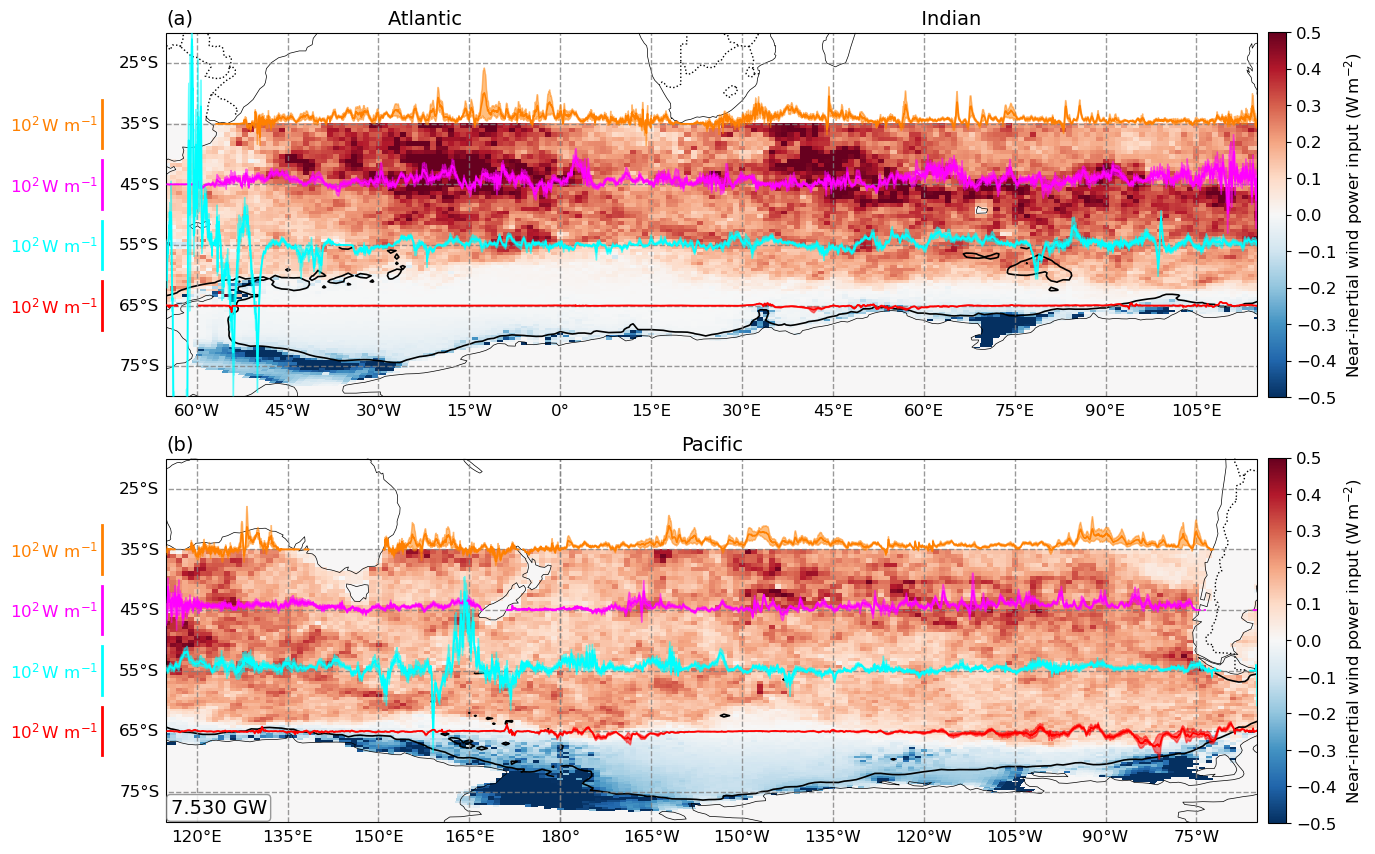

In [21]:
niw_background, vmin, vmax, cmap  = 'niw_bandpass', -0.5, 0.5, 'RdBu_r'

# ------------------------------------------------------------------
#  CONSTANTS / INPUTS ----------------------------------------------
# ------------------------------------------------------------------
latitudes   = [-35, -45, -55, -65]
datasets    = [ds_Edz_35S_sorted_nonnan, ds_Edz_45S_sorted_nonnan, ds_Edz_55S_sorted_nonnan, ds_Edz_65S_sorted_nonnan]
colors      = ['#ff8000', '#ff00ff', 'cyan', 'red']
scales      = [1e2, 1e2, 1e2, 1e2]
labels_txt  = [r'$10^2\,$W m$^{-1}$',
               r'$10^2\,$W m$^{-1}$',
               r'$10^2\,$W m$^{-1}$',
               r'$10^2\,$W m$^{-1}$']
plot_scale  = 8
desired_lats = [-25, -35, -45, -55, -65, -75]
x_frac_bar  = 0.16                    # bar position in figure-fraction

# ------------------------------------------------------------------
#  FIGURE & 2 SUBPLOTS ---------------------------------------------
# ------------------------------------------------------------------
fig = plt.figure(figsize=(16, 11))
ax1 = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=180))

fig.subplots_adjust(left=0.20, hspace=0.01)

def plot_panel(ax, extent, central_lon, ticks):
    # ------------ background --------------------------------------
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    d = 48 # you can coarsen the bathymetry resolution

    if central_lon == 0:
        ds_plot = ds_niw_z_180
    else:
        ds_plot = ds_niw_z_360
        
    p = ax.pcolormesh(ds_plot['lon'].values[::d, ::d],
                      ds_plot['lat'].values[::d, ::d],
                      1e3 * ds_plot[niw_background][::d, ::d],
                      shading='auto', cmap=cmap, vmin = vmin, vmax = vmax, transform=ccrs.PlateCarree())

    # ------------ flux lines --------------------------------------
    for lat, ds, col, scl in zip(latitudes, datasets, colors, scales):
        flux = plot_scale * (ds['Ecl_inertial_dz_mean'] / scl).values.squeeze()
        flux_std = plot_scale * (ds['Ecl_inertial_dz_monthly_error'] / scl).values.squeeze()
        lon = ds['lon'].values
        ax.plot(lon, lat + flux, color=col, lw=1.2,transform=ccrs.PlateCarree(), zorder=4)
        
        upper = lat + flux + flux_std
        lower = lat + flux - flux_std
        
        ax.fill(
            np.concatenate([lon, lon[::-1]]),
            np.concatenate([upper, lower[::-1]]),
            color=col, alpha=0.5, transform=ccrs.PlateCarree(), zorder=3
        )

    # ------------ reference bars & labels ------------------------
    trans = mtransforms.blended_transform_factory(fig.transFigure, ax.transData)
    half_bar = 0.5 * plot_scale
    for lat, col, lab in zip(latitudes, colors, labels_txt):
        # bar
        fig.add_artist(mlines.Line2D([x_frac_bar, x_frac_bar],
                                     [lat - half_bar, lat + half_bar],
                                     transform=trans,
                                     color=col, lw=2, zorder=5))
        # label
        ax.annotate(lab, xy=(x_frac_bar, lat),
                    xycoords=trans, xytext=(-3, 0),
                    textcoords='offset points',
                    ha='right', va='center',
                    color=col, fontsize=12, clip_on=False, zorder=6)

    # Colorbar
    cbar = plt.colorbar(p, ax=ax, orientation='vertical',pad=0.01, fraction=0.0163)
    cbar.set_label(r'Near-inertial wind power input $(\mathrm{W\,m^{-2}})$', fontsize=12) 
    cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize=12)    

    # 2000 m isobath
    ax.contour(
        ds_plot['lon'][::d, :4500:d].values,
        ds_plot['lat'][::d, :4500:d].values,
        ds_plot['bottom_depth'][::d, :4500:d].values,
        levels=[2000], colors='black', linewidths=1.2, linestyles='-',
        transform=ccrs.PlateCarree(), zorder=2
    )
    
    
    # ------------ map  --------------------------------
    ax.add_feature(cfeature.COASTLINE, lw=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax.gridlines(draw_labels=True, linewidth=1,
                      color='gray', alpha=0.8, linestyle='--')
    gl.right_labels   = False   # ← hide left latitude labels
    gl.top_labels    = False   #   (optional: hide top lon labels)
    gl.xlabel_style  = {'size': 12}
    gl.ylabel_style  = {'size': 12}
    desired_lats = [-25,-35, -45, -55, -65,-75]
    gl.ylocator  = mticker.FixedLocator(desired_lats)
    gl.xlocator = MultipleLocator(15)
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    
# ------------------------------------------------------------------
#  DRAW PANELS ------------------------------------------------------
# ------------------------------------------------------------------
plot_panel(ax1, [-65, 115, -80, -20], central_lon = 0,   ticks=np.arange(-0.5, 0.55, 0.1))   
plot_panel(ax2, [115, 295, -80, -20], central_lon = 180, ticks=np.arange(-0.5, 0.55, 0.1))   

ax1.text(0.0, 1.065, '(a)', transform=ax1.transAxes, fontsize=14, va='top')
ax2.text(0.0, 1.065, '(b)', transform=ax2.transAxes, fontsize=14, va='top')

ax2.text(
    0.092, 0.065, f"{7.530:.3f} GW",
    transform=ax2.transAxes,
    ha='right', va='top', fontsize=14,
    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='gray', alpha=0.8)
)

# ------------------------------------------------------------------
#  TITLES -----------------------------------------------------------
# ------------------------------------------------------------------
ax1.set_title('Atlantic                                                                           Indian         ', fontsize=14)
ax2.set_title('Pacific', fontsize=14)
plt.show()
